# Анализ окупаемости привлечения пользователей

В данном проекте нам необходимо сделать вывод касательно успешности затрат на рекламу, насколько успешным является привлечение пользователей, сколько из них превращается в платящих, сколько продолжает пользоваться приложением.

В данном проекте у нас есть три таблицы с информацией о посещениях сайта, заказах и затратах на рекламу. В этих таблицах есть информация о пользователях, их пользовании приложения - с каких девайсов, в каких регионах, с каких каналов рекламы они пришли, информация о их сессиях в приложении.

В процессе анализа будет необходимо понять с каких рекламных каналов приходят пользователи, какими устройствами они пользуются, проанализировать затраты на различные рекламные каналы, понять, сколько в действительности приносит каждый клиент, когда расходы на привлечение клиента окупаются,и какие факторы мешают привлечению клиентов.

Для выполнения поставленной задачи необходимо изучить данные, подготовить функции для расчета необходимых показателей, проанализировать данные - составить профили пользователей, выяснить, какие регионы самые популярные среди них, какие устройства они используют для входа в приложения, как они пришли в приложение. Далее необходимо проанализировать насколько успешными являются действия отдела маркетинга и посмотреть, на какие каналы привлечения уходят средства, сколько приносят пользователи приложения, пришедшие с рекламы, сколько стоило привлечение пользователей, оценить сколько они приносят компании после пользования приложения. И в конце уже посмотреть, окупаются ли затраты на маркетинг или стоит пересмотреть их распределение. Сделать вывод на основании проведенного исследования.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [2]:
visits.info()
visits = visits.rename(columns={'User Id':'user_id', 'Session Start':'session_start', 'Session End':'session_end',\
                                'Region':'region', 'Device':'device','Channel':'channel'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
 visits.duplicated().sum()

0

In [4]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [5]:
orders.info()
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt','Revenue':'revenue'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [7]:
orders.duplicated().sum()

0

In [8]:
costs.info()
costs = costs.rename(columns={'Channel':'channel'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [9]:
print(costs)

              dt         channel  costs
0     2019-05-01        FaceBoom  113.3
1     2019-05-02        FaceBoom   78.1
2     2019-05-03        FaceBoom   85.8
3     2019-05-04        FaceBoom  136.4
4     2019-05-05        FaceBoom  122.1
...          ...             ...    ...
1795  2019-10-23  lambdaMediaAds    4.0
1796  2019-10-24  lambdaMediaAds    6.4
1797  2019-10-25  lambdaMediaAds    8.8
1798  2019-10-26  lambdaMediaAds    8.8
1799  2019-10-27  lambdaMediaAds   12.0

[1800 rows x 3 columns]


In [10]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [11]:
costs.duplicated().sum()

0

In [12]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Пропусков в данных не обнаружено. Полных дубликатов в данных не обнаружено. Столбцы с данными о датах и времени во всех таблицах приведены к нужному типу данных. 

In [13]:
def get_profiles(visits, orders, costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    #for event in event_names:
        #if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            #profiles[event] = profiles['user_id'].isin(
                #events.query('event_name == @event')['user_id'].unique()
            #)

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles
    


In [14]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [15]:
observation_date = datetime(2019, 10, 1).date()  
print(observation_date)
horizon_days = 14

2019-10-01


In [16]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    retention_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    retention_raw = retention_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    retention_raw['lifetime'] = (retention_raw['session_start'] - retention_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    # расчитываем удержание 
    retention_grouped = group_by_dimensions(retention_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    retention_in_time = group_by_dimensions(retention_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return retention_raw, retention_grouped, retention_in_time

  


In [17]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days, dimensions = [])

In [18]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [19]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date,horizon_days, dimensions=[], ignore_horizon=False)

С тем вроде разобралась, но теперь здесь ошибку выдает "No group keys passed!"

In [20]:
def get_conversion(
    profiles,
    purchases, 
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Шаг 1. Получить пользовательские профили и данные о покупках
    # передаём их в качестве аргументов profiles и purchases

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    conversion_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Найти дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # Шаг 3. Добавить данные о покупках в профили
    conversion_raw = conversion_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # Шаг 4. Рассчитать лайфтайм для каждой покупки
    conversion_raw['lifetime'] = (
        conversion_raw['event_dt'] - conversion_raw['first_ts']
    ).dt.days
    # этот столбец мы будем использовать для группировки в случае, когда в dimensions ничего не передано
    if len(dimensions) == 0:
        conversion_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']  

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 5. Построить таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        # Шаг 6. Посчитать сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)

        # Шаг 7. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 8. Объединить таблицы размеров когорт и конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 9. Разделить каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)

        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    conversion_grouped = group_by_dimensions(conversion_raw, dimensions, horizon_days)

    # получаем таблицу динамики конверсии
    conversion_in_time = group_by_dimensions(
        conversion_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return conversion_raw, conversion_grouped, conversion_in_time 

In [21]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles, orders, observation_date, horizon_days)

In [22]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [23]:
def plot_retention(retention, retention_history, horizon):

    # задаём размер сетки для графиков
    plt.figure(figsize=(30, 15))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # исключаем наложение графиков друг на друга
    plt.tight_layout()

    plt.show()



In [24]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(30, 15))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_in_time = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()
 

In [25]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(30, 20))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [26]:
#создаем профили и вычисляем минимальную и максимальные даты
profiles = get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [27]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print(min_date)
print(max_date)

2019-05-01
2019-10-27


Первые пользователи были привлечены первого мая 2019 года, последние - 27 октября 2019 года, то есть промежутком для анализа будут выступать чуть меньше полугода.

In [28]:
regions = profiles.pivot_table(index = 'region', values='user_id', aggfunc='count')
payers = profiles.query('payer == True').pivot_table(index='region', values='user_id', aggfunc='count')
regions['percent'] = payers/regions
#print(payers)
#print(regions.sort_values(by='user_id', ascending=False))

Больше всего пользователей приходит из США, возможно это связано с тем, что в США численность населения больше, чем в остальных странах. Из США как раз и самая высокая доля платящих пользователей - 7%, из Германии немного меньше - 4% 

In [29]:
devices=profiles.pivot_table(index='device', values='user_id', aggfunc='count') 
devices_payers = profiles.query('payer == True').pivot_table(index='device', values='user_id', aggfunc='count')
devices['percent']=devices_payers/devices
print(devices.sort_values(by='user_id', ascending=False))

         user_id   percent
device                    
iPhone     54479  0.062079
Android    35032  0.058518
PC         30455  0.050468
Mac        30042  0.063644


Большинство пользователей предпочитают iPhone для использования приложения. Но большинство платящих пользователей приходится на тех, кто использует Mac, почти 6.4%, на втором месте с совсем небольшим отрывом пользователи iPhone- 6.2%

In [30]:
ads_channels=profiles.pivot_table(index='channel', values='user_id', aggfunc='count') 
ads_payers = profiles.query('payer == True').pivot_table(index='channel', values='user_id', aggfunc='count')
#print(ads_payers)
ads_channels['percent']=round(ads_payers*100/ads_channels, 2)
print(ads_channels.sort_values(by='percent', ascending=False))

                    user_id  percent
channel                             
FaceBoom              29144    12.20
AdNonSense             3880    11.34
lambdaMediaAds         2149    10.47
TipTop                19561     9.60
RocketSuperAds         4448     7.91
WahooNetBanner         8553     5.30
YRabbit                4312     3.83
MediaTornado           4364     3.57
LeapBob                8553     3.06
OppleCreativeMedia     8605     2.71
organic               56439     2.06


Большинство пользователей приходят органически больше 56 тысяч пользователей, тем не менее всего 2% из этих пользователей являются платящими. FaceBoom является одним из лучших каналов привленчения пользователя, он привел 29 тысяч пользователей и является самым удачным каналом по привлечению именно платящих пользователей, их 12%. По кол-ву привлеченных пользователей на третьем месте TipTop  - 19,5 тысяч пользователей. А по привлечению именно платящих пользователей на втором месте стоит AdNonSense - 11%

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [31]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
print(costs)

              dt         channel  costs  week  month
0     2019-05-01        FaceBoom  113.3    18      5
1     2019-05-02        FaceBoom   78.1    18      5
2     2019-05-03        FaceBoom   85.8    18      5
3     2019-05-04        FaceBoom  136.4    18      5
4     2019-05-05        FaceBoom  122.1    18      5
...          ...             ...    ...   ...    ...
1795  2019-10-23  lambdaMediaAds    4.0    43     10
1796  2019-10-24  lambdaMediaAds    6.4    43     10
1797  2019-10-25  lambdaMediaAds    8.8    43     10
1798  2019-10-26  lambdaMediaAds    8.8    43     10
1799  2019-10-27  lambdaMediaAds   12.0    43     10

[1800 rows x 5 columns]


In [32]:
sum_costs = costs['costs'].sum()
print('Общие затраты на рекламу:', sum_costs.round())

channel_costs = costs.pivot_table(index='channel', values='costs', aggfunc='sum')
print(channel_costs.sort_values(by='costs', ascending=False))

Общие затраты на рекламу: 105497.0
                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22


Выше был сделан вывод, что наилучший показатель по привлечению платящих пользователей показывают FaceBoom и TipTop, а исходя из данной таблицы по распределению затрат на рекламу, как раз на эти каналы привлечения пользователей и приходятся наибольшие затраты

Text(0.5, 1.0, 'Распределение затрат по месяцам')

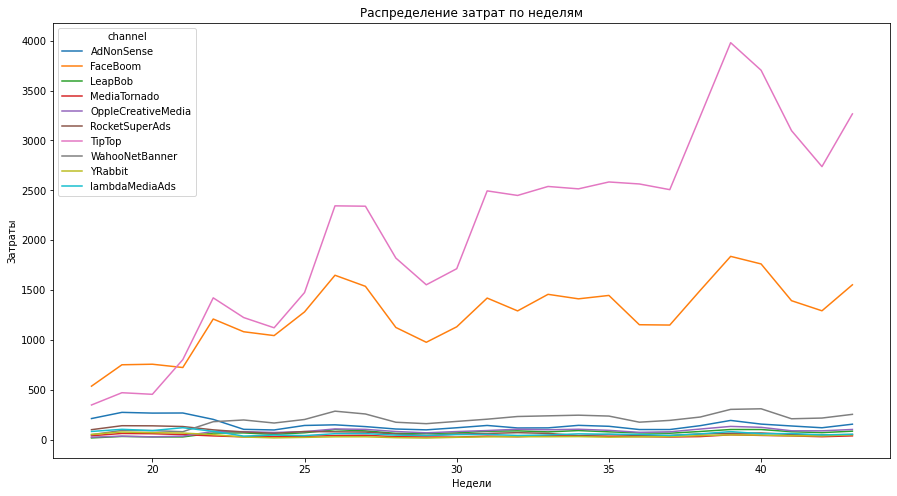

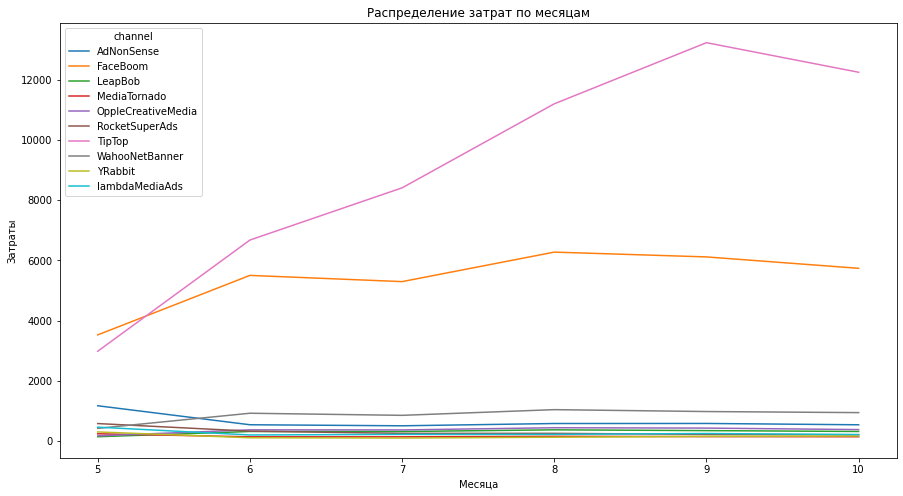

In [33]:
weekly_costs = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
monthly_costs = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

weekly_costs.plot(figsize=(15,8))
plt.xlabel('Недели')
plt.ylabel('Затраты')
plt.title('Распределение затрат по неделям')
monthly_costs.plot(figsize=(15,8))
plt.xlabel('Месяца')
plt.ylabel('Затраты')
plt.title('Распределение затрат по месяцам')

Расходы на рекламу по всем каналам, кроме FaceBoom и TipTop, на протяжении всего времени не претерпивают особых изменений, находятся примерно на одном уровне, если смотреть по месяцам, то их уровень не превышает 2000. 
Что касается FaceBoom и TipTop, затраты на данные каналы с течением времени увеличиваются, на TipTop они растут более заметно. 

In [34]:
number_of_users = profiles['user_id'].count()
#print(number_of_users)
cac_total = profiles['acquisition_cost'].sum()
avg_cac_per_user = cac_total/number_of_users
print(avg_cac_per_user)

0.7032778251826568


In [35]:
avg_cac_per_channel = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
print(avg_cac_per_channel.sort_values(by='acquisition_cost', ascending=False))

                    acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000


Если рассматривать среднее CAC по всему проекту, то оно равно 0.7, в то же время отдельно по каналам оно равно 2.8 для TipTop, 1.1 для FaceBoom и 1 для AdNonSense, это топ-3 по затратам на привлечение. 

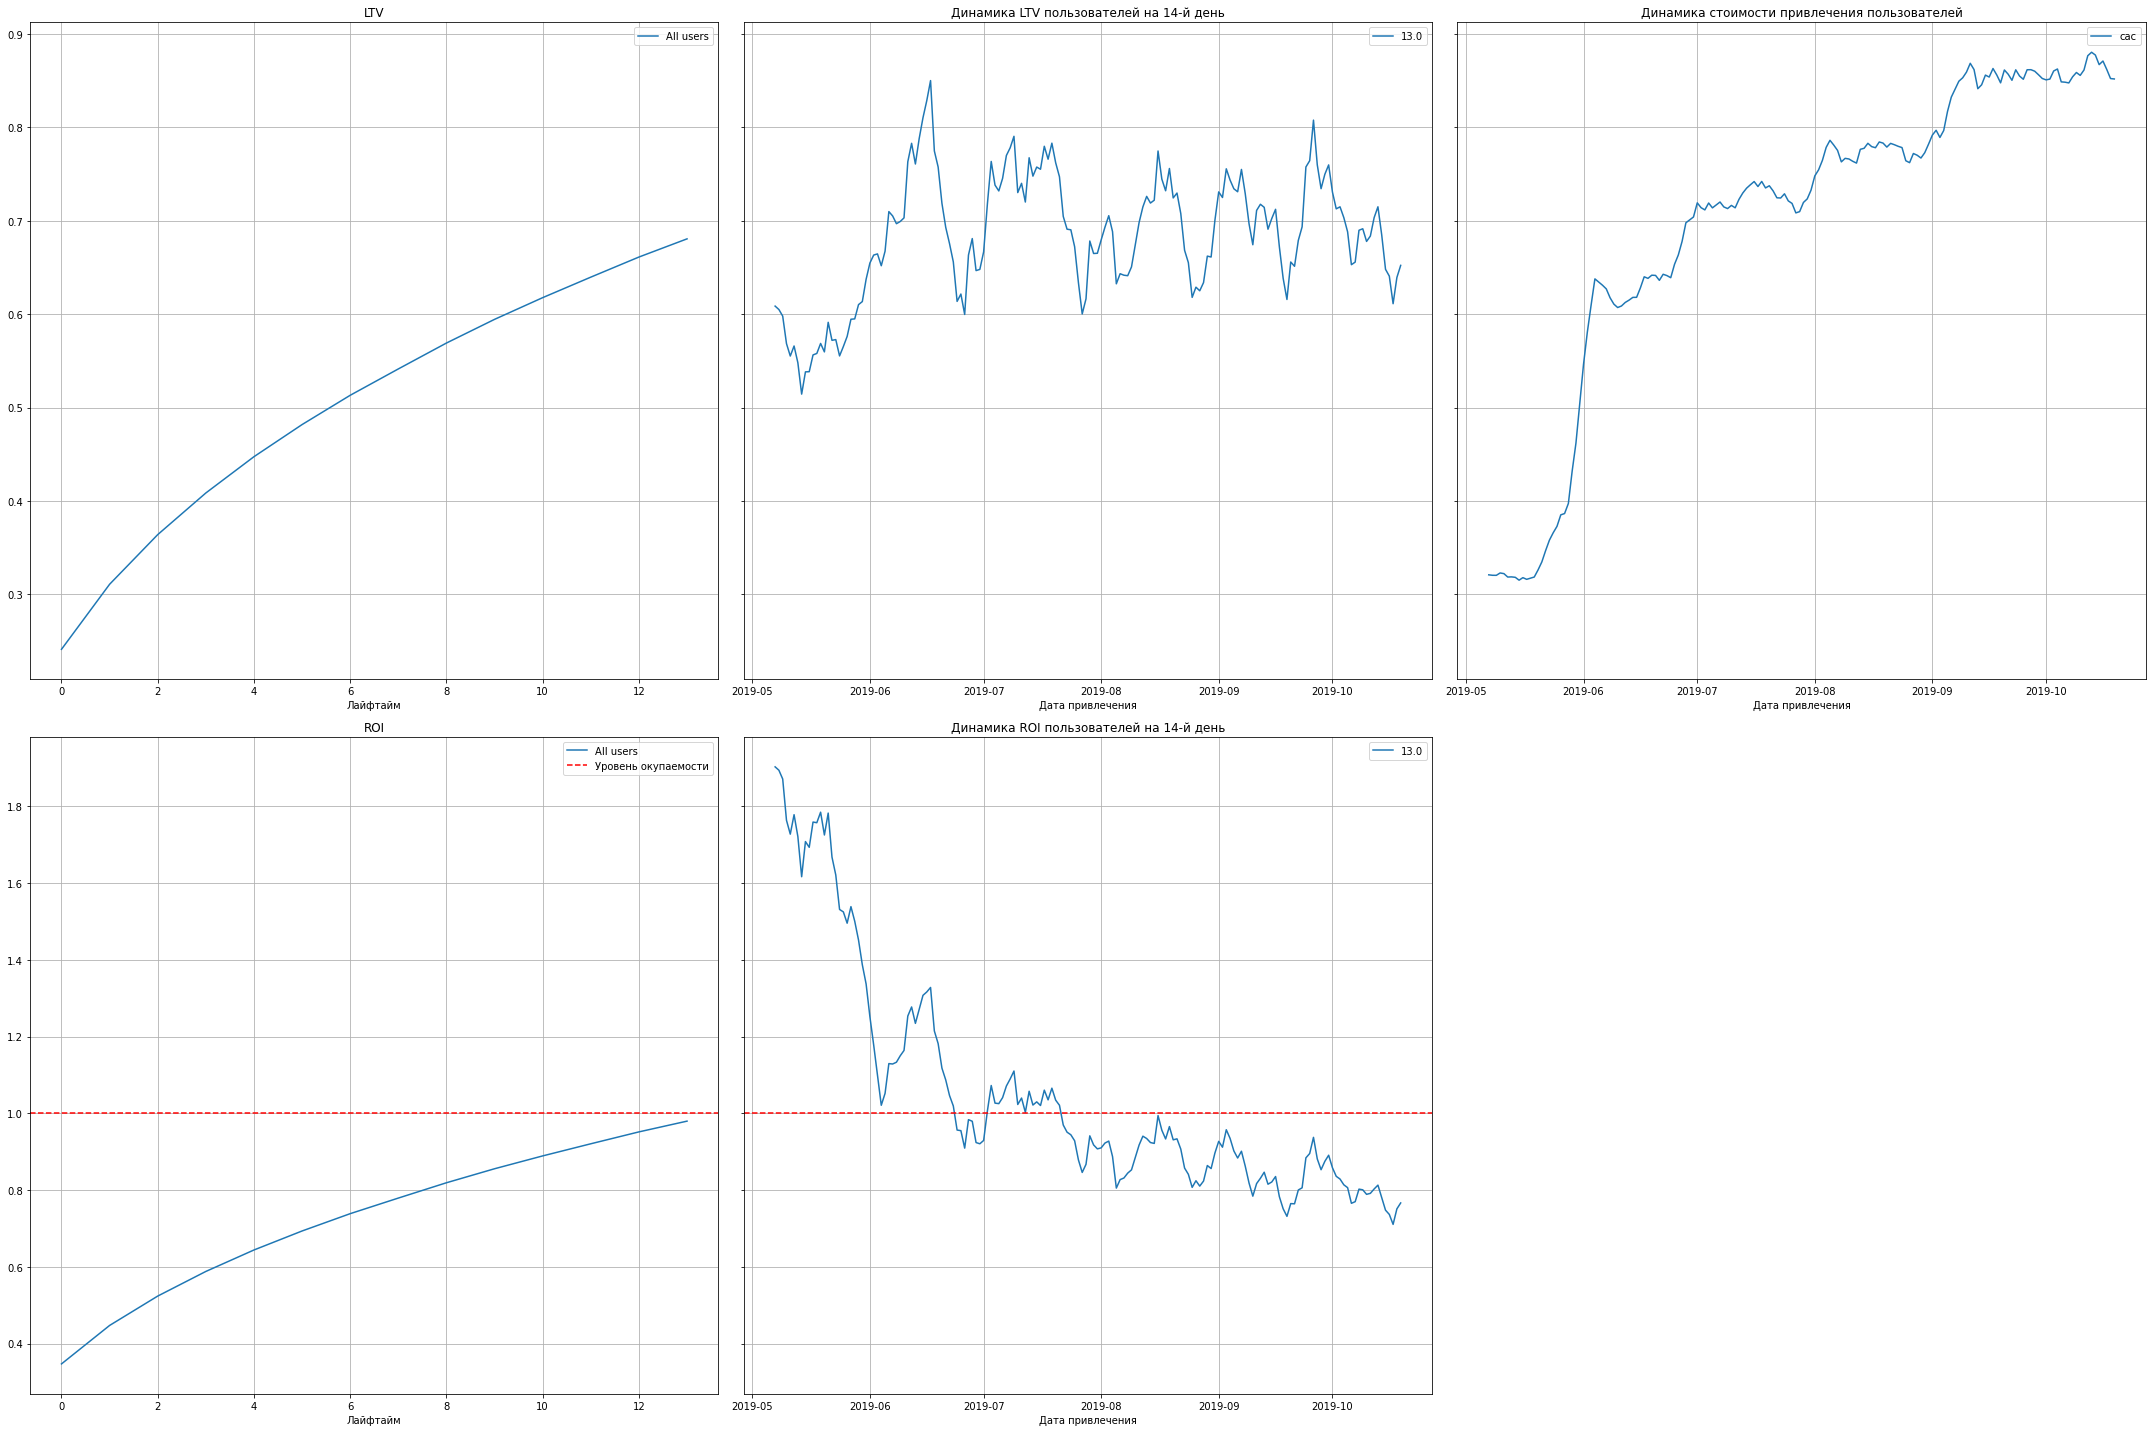

In [36]:
observation_date = datetime(2019, 11, 1).date()

horizon_days = 14



result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date, horizon_days)

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

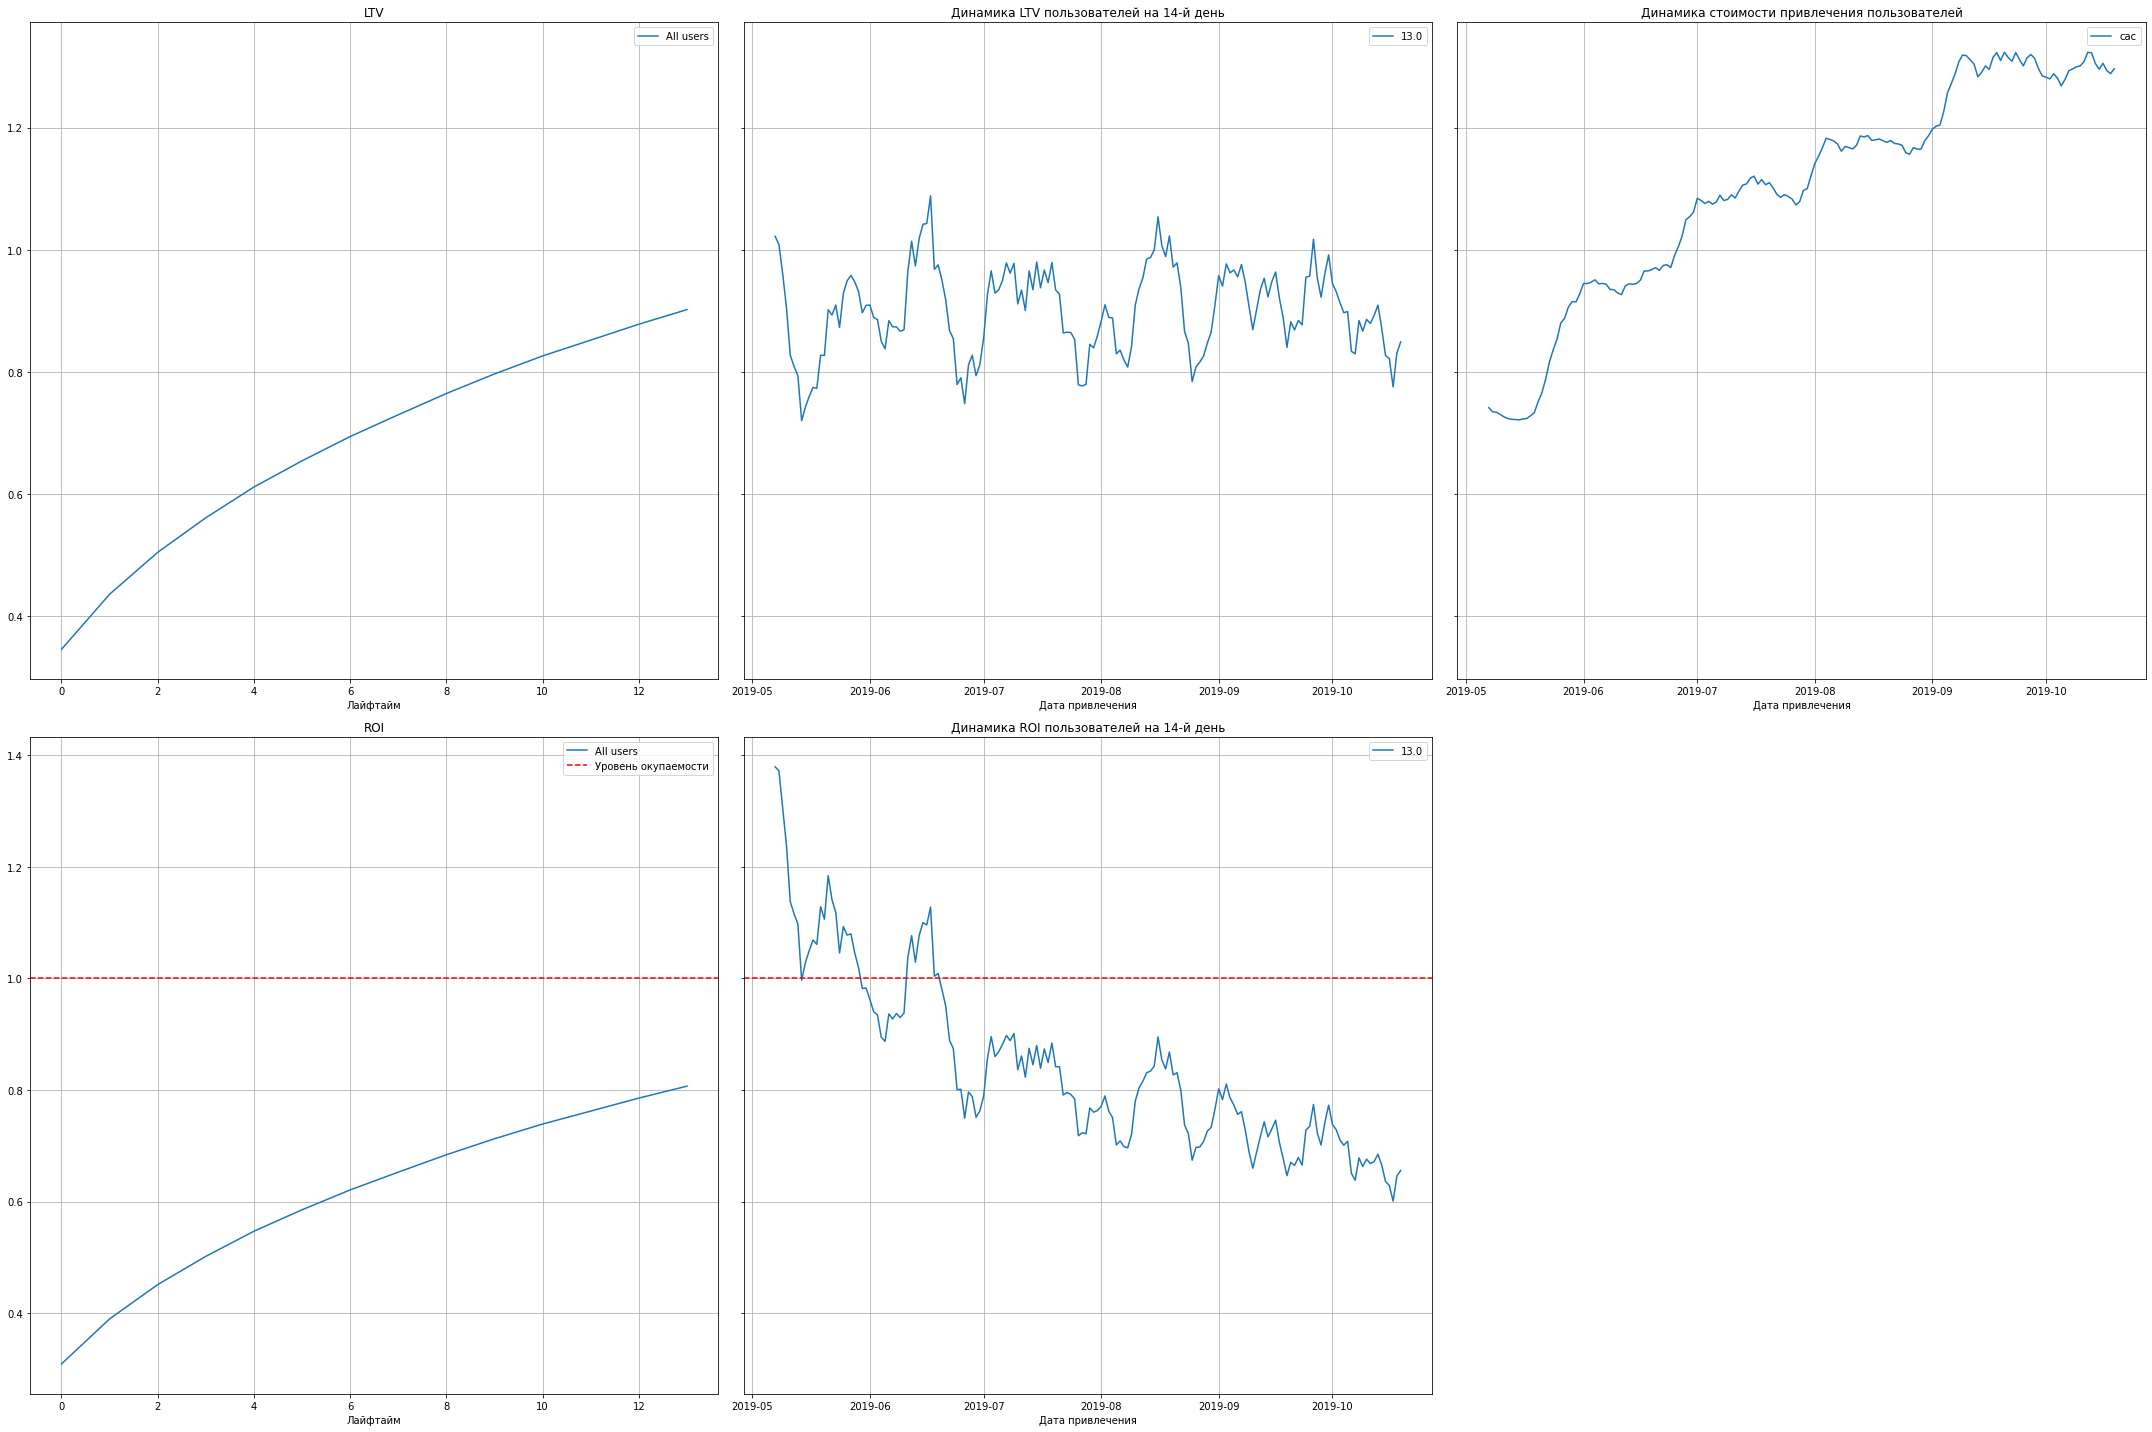

In [37]:
#без учета органики
profiles_no_orgnic = profiles.query('channel != "organic"')
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles_no_orgnic, orders, observation_date, horizon_days)

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

Реклама окупается, если опираться на график ROI и его динамики на 14-й день, на нем крайне заметно, как к 14-му дню кривая опускается гораздо ниже уровня окупаемости. К тому же на графике стоимости привлечения пользователей демонстрируется, как сильно она растет. LTV имело достаточно хаотичное движение на протяжении изучаемых двух недель, и практически все время кривая находится ниже единицы.

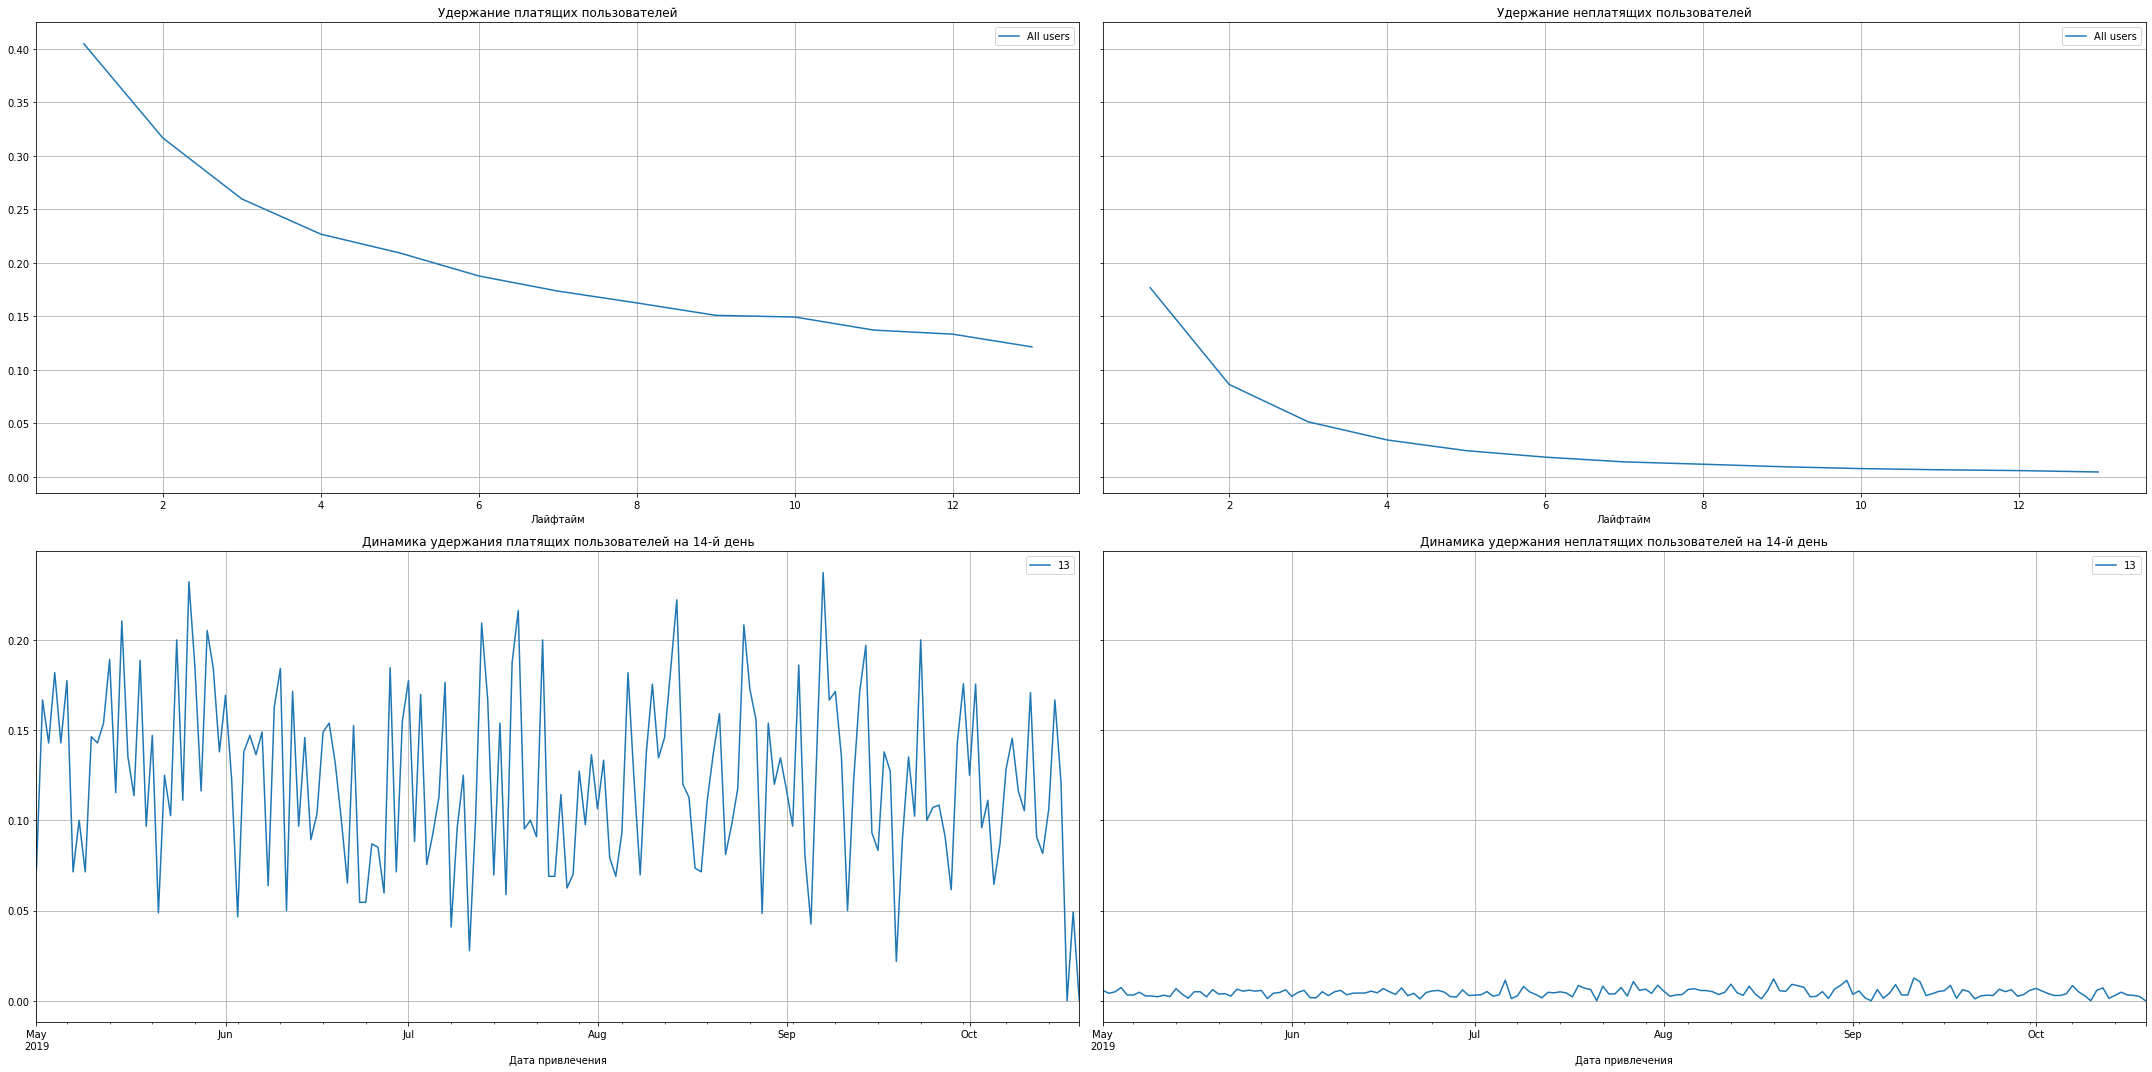

In [38]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days, dimensions = [])

plot_retention(retention_grouped, retention_in_time, horizon_days)

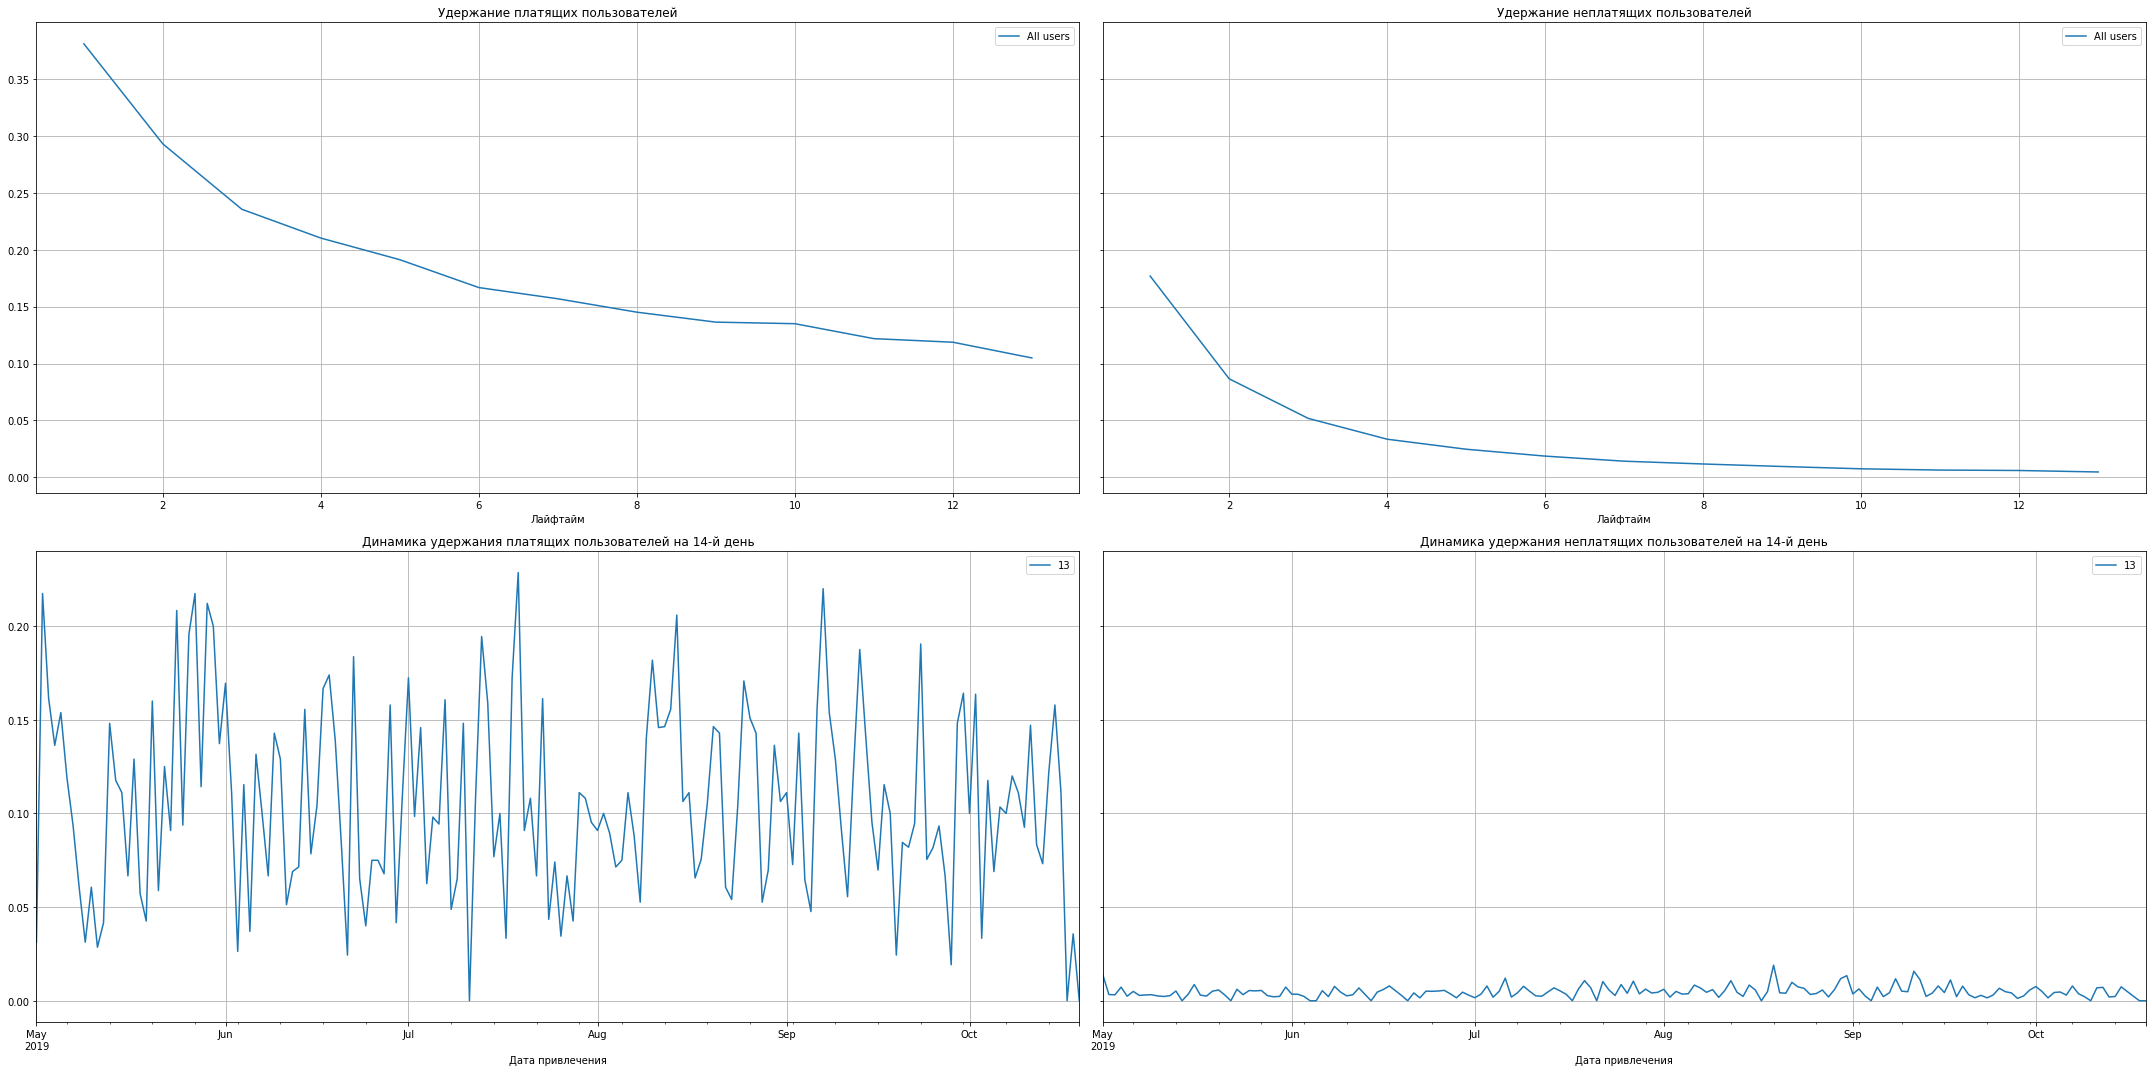

In [39]:
#без учета органики
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_no_orgnic, visits, observation_date, horizon_days, dimensions = [])

plot_retention(retention_grouped, retention_in_time, horizon_days)

Удержание пользователей сложно назвать успешным, на графике с динамикой видно, что к концу рассматриваемого периода их количество крайне приближено к 0. Удержание неплатящих пользователей резко падает уже к 4 дню, а платящих к 6.

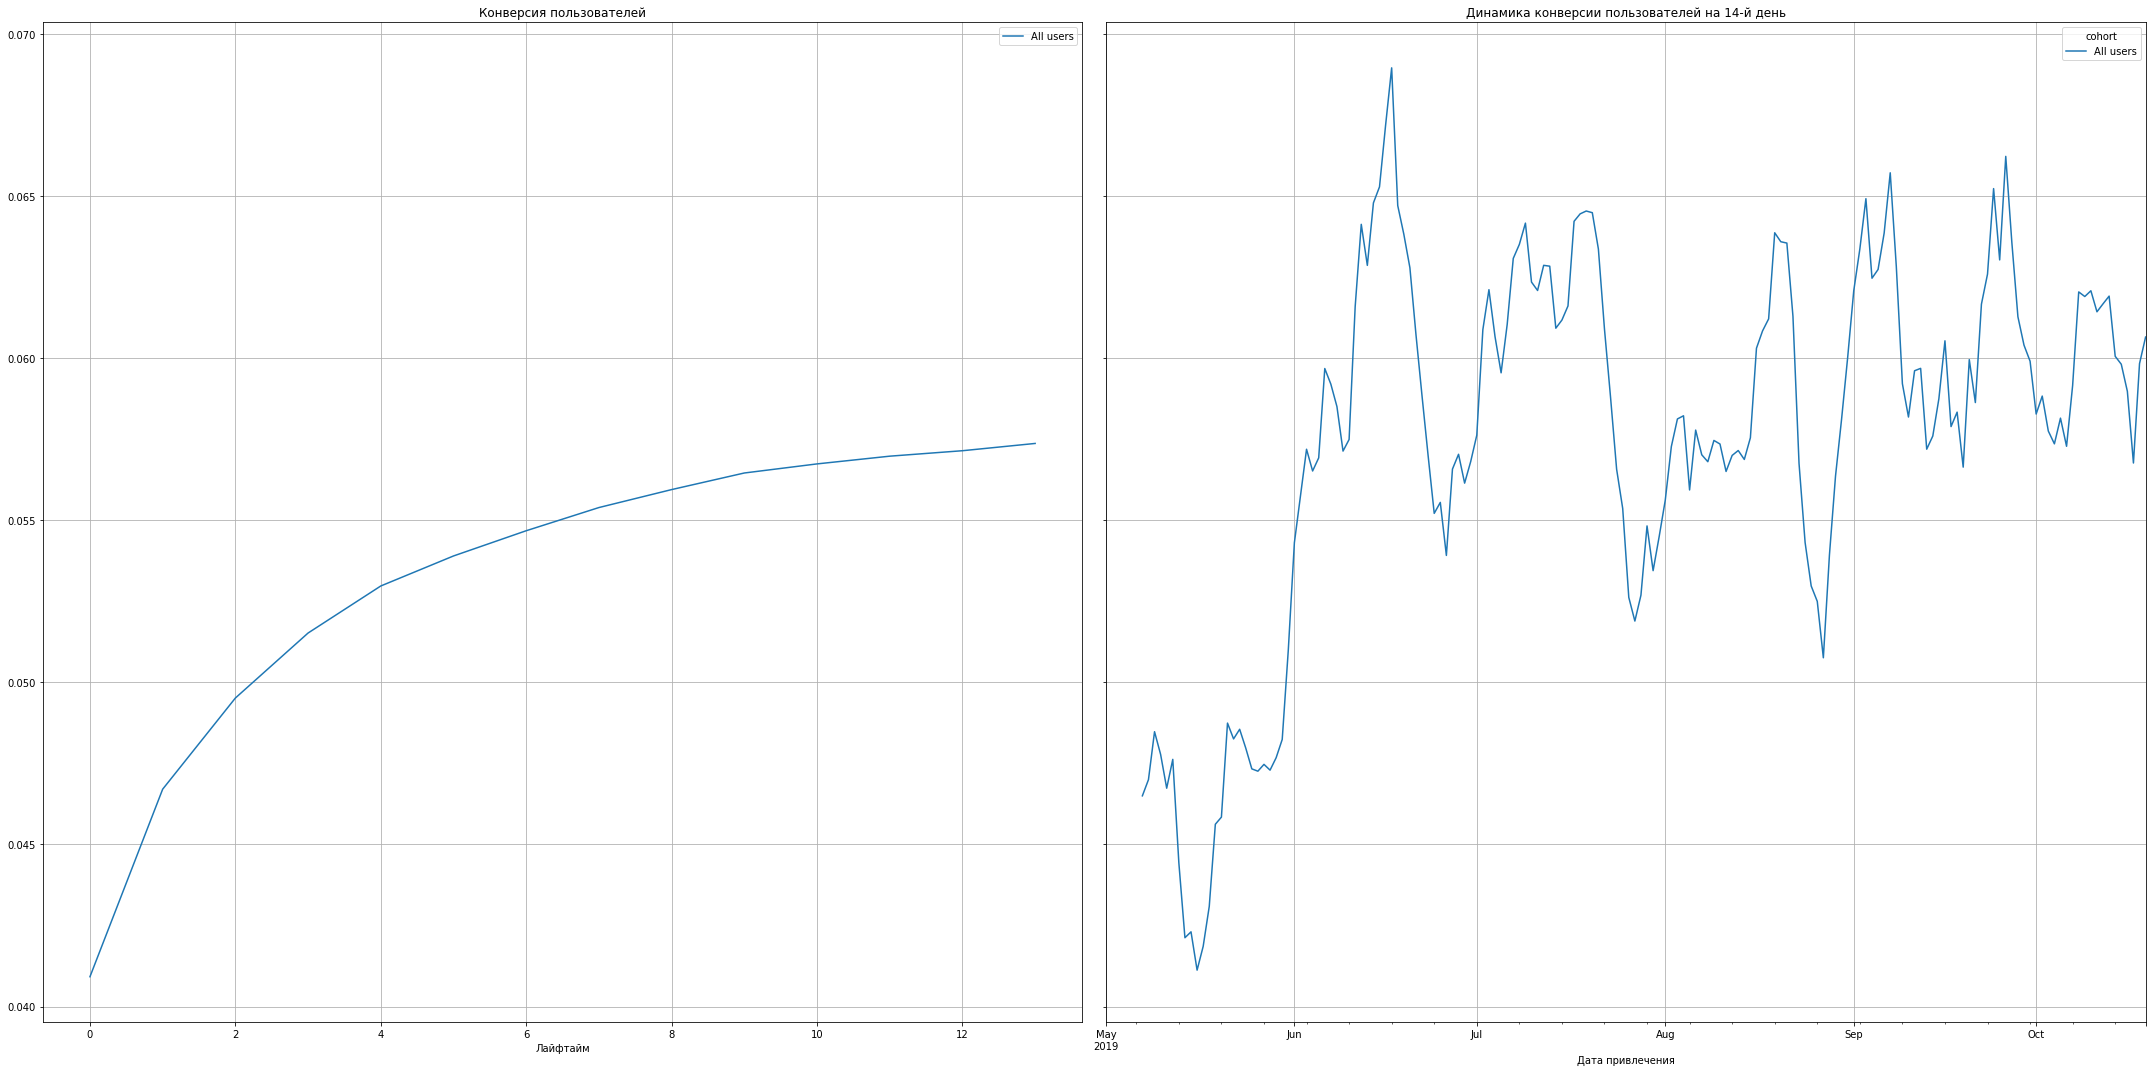

In [40]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

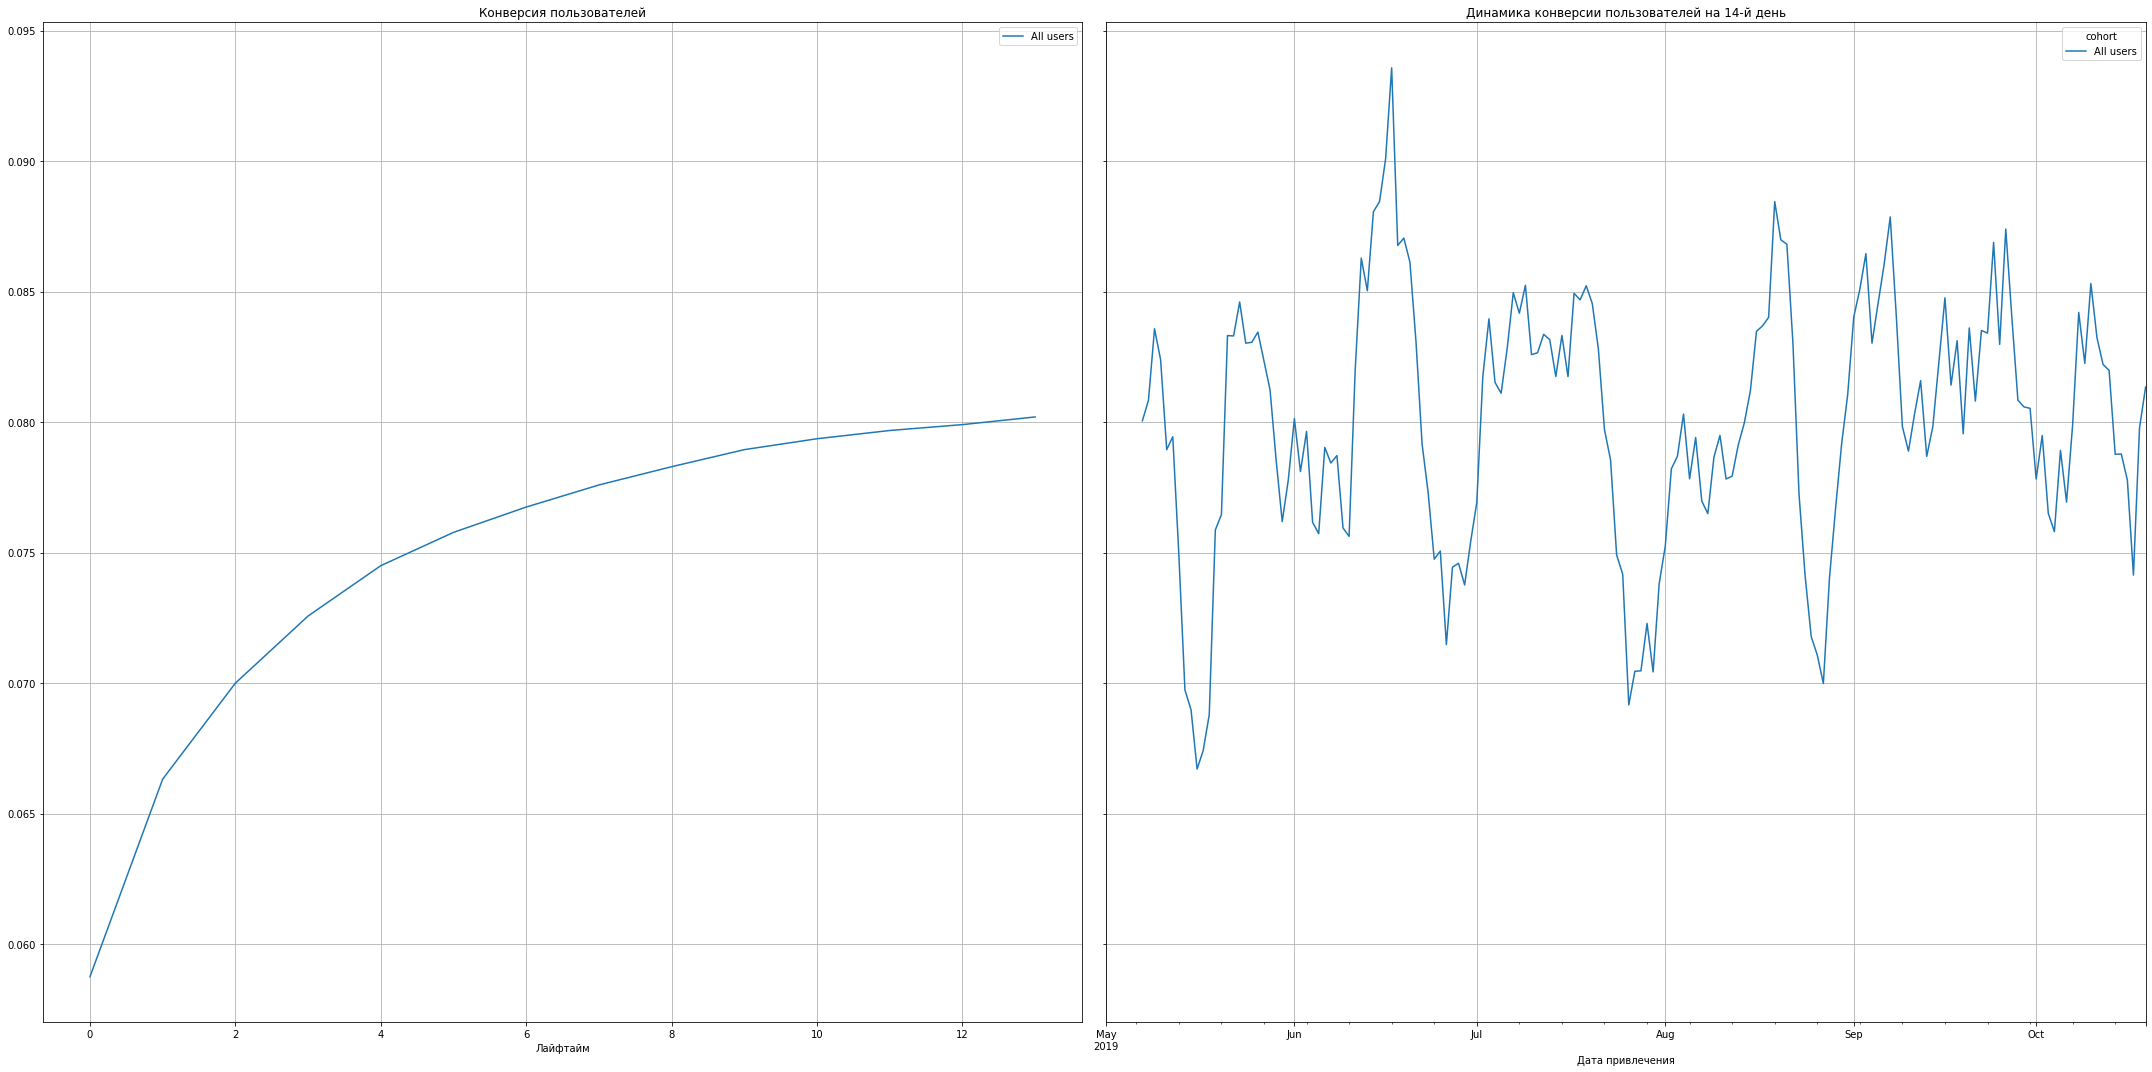

In [41]:
#без учета органики
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles_no_orgnic, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

Если посмотреть на динамику конверсии, то можно предположить, что в среднем на протяжении 14 дней она держалась на одном уровне.

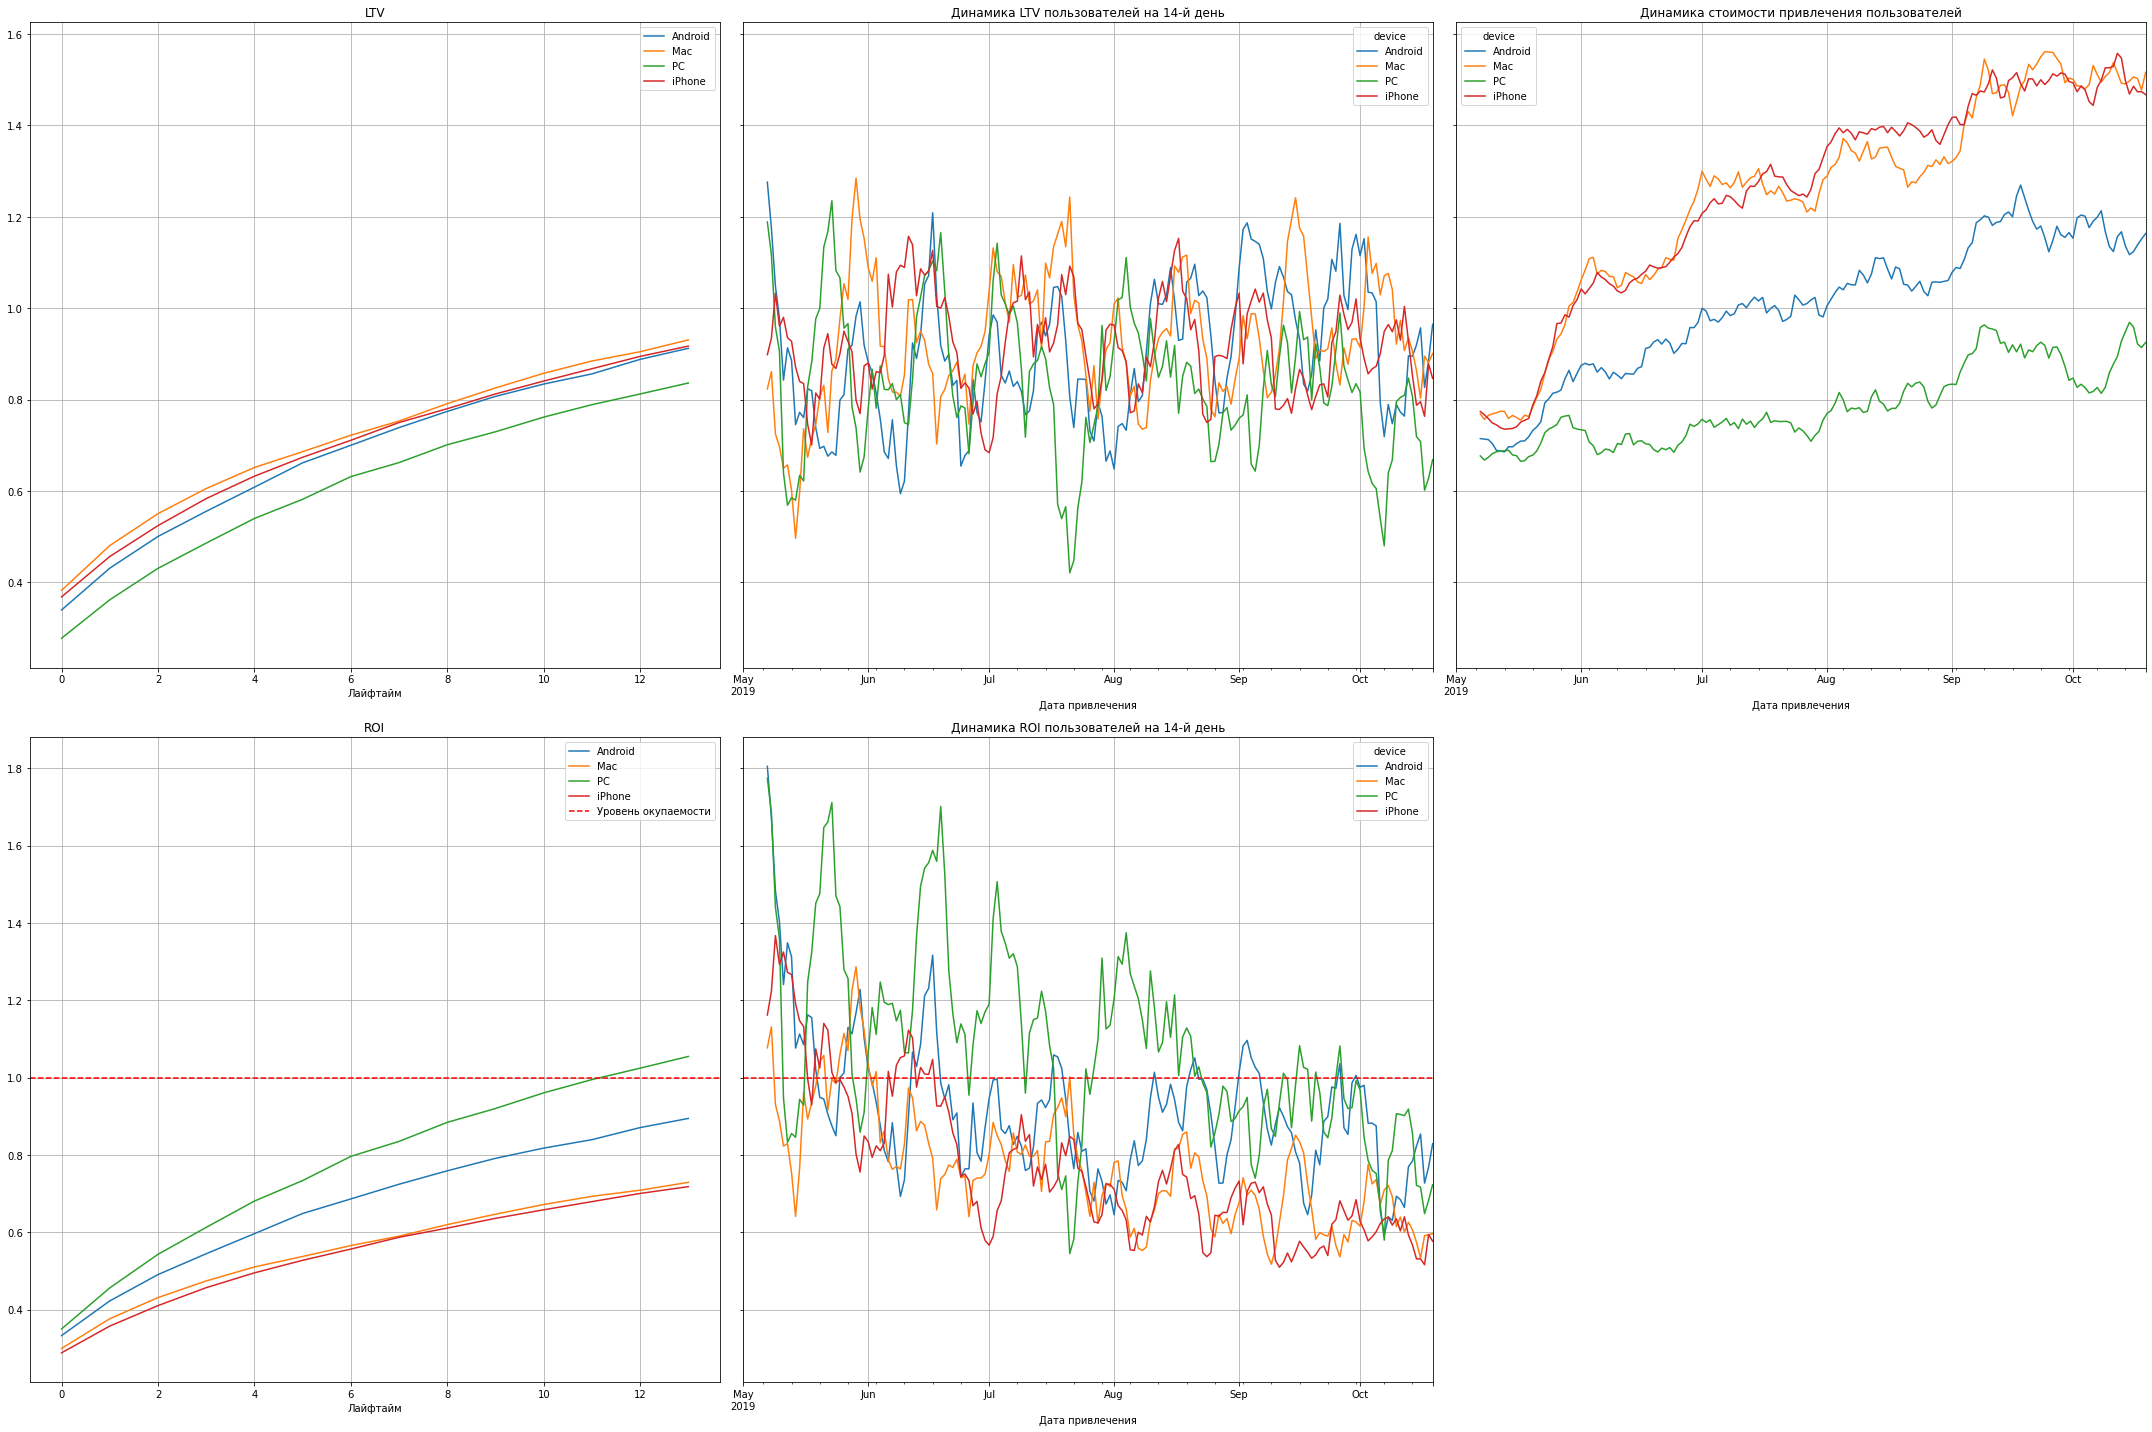

In [42]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles_no_orgnic, orders, observation_date, horizon_days, dimensions = ['device'])

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

Проанализировав графики выше, самый лучший показатель из девайсов демонстрирует PC. Затраты на рекламу для PC растут не так активно, как для остальных девайсов, скорее всего этот фактор и влияет на то, что только для PC ROI со времене и превышает уровень окупаемость. LTV ниже всех для пользователей, использующих PC, и в динамике именно грфик по PC проседает ниже всех.

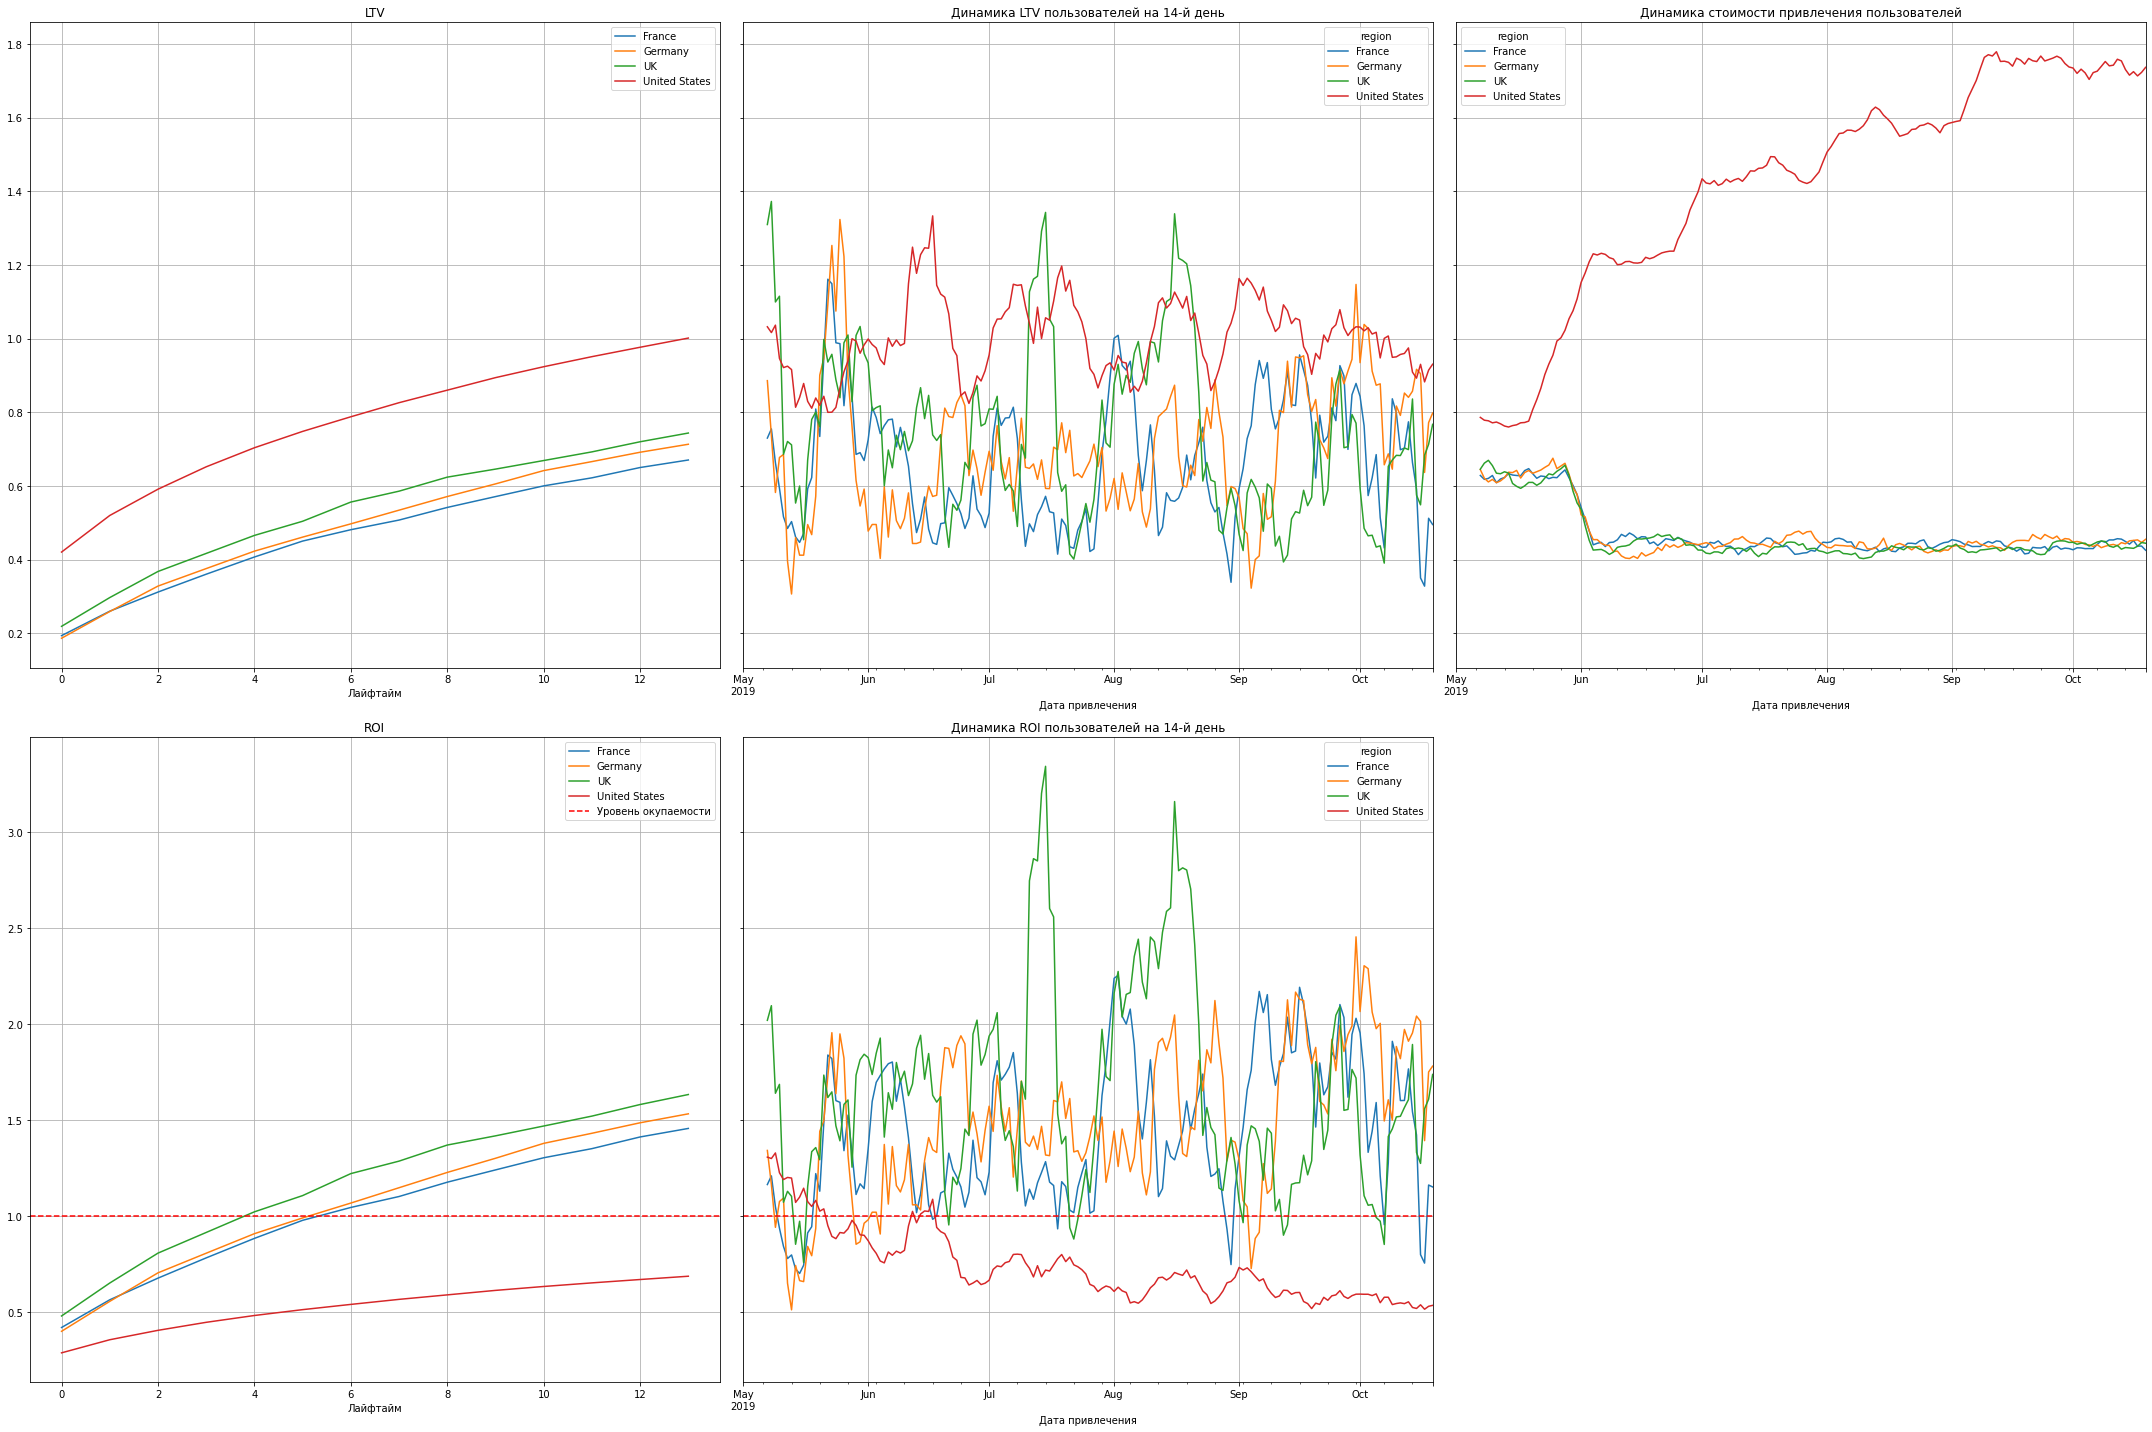

In [43]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles_no_orgnic, orders, observation_date, horizon_days, dimensions = ['region'])

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

Из графиков можно сделать вывод, что несмотря на то, что в США пожизненная ценность клиентов выше, чем в других регионах, стоимость привлечения клиентов в СШа в разы выше, чем в остальных регионах и по итогу она просто не окупается. Об этом свидетельствует и график динамики ROI на 14-й день, именно по США он падает ниже уровня окупаемости. У остальных же регионов показатели примерно равны, и динамика стоимости привлечения у них довольно низкая, и в это же время их окупаемость растет.

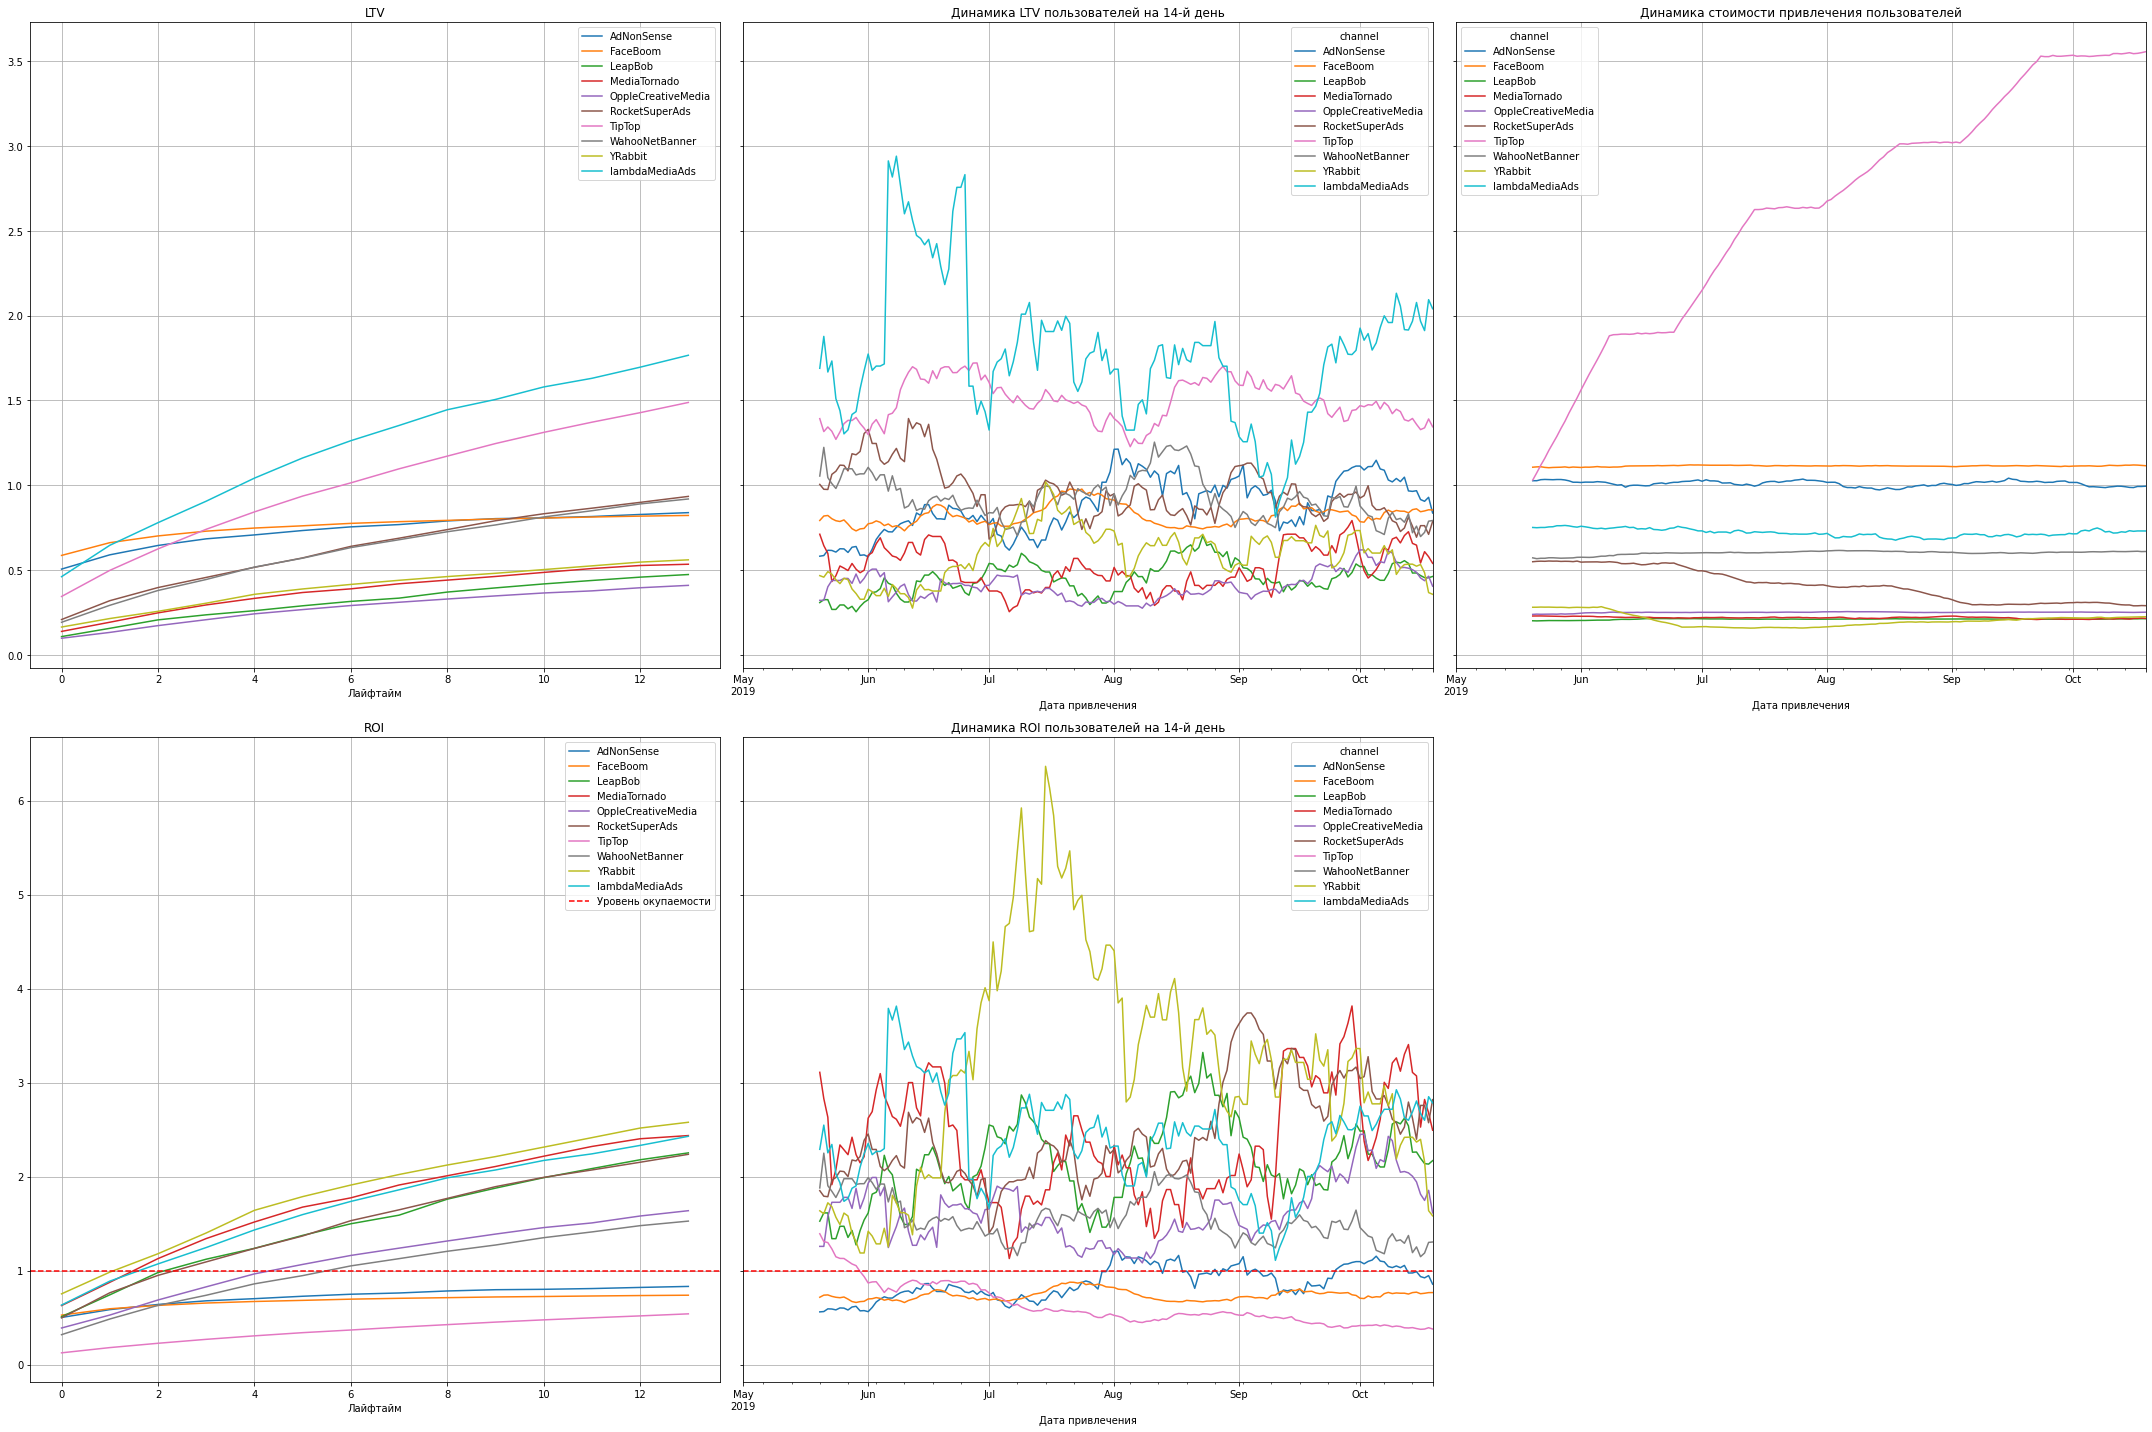

In [44]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles_no_orgnic, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=20)


Что касается окупаемости рекламы по каналам, несмотря на успешность привлечения пользователей каналами TipTop, AdNonSense и FaceBoom, которая была продемонстрирована ранее, именно они не показывают положительных результатов окупаемости, а на TipTop еще и крайне сильно растут затраты. Зато lambdaMediaAds и TipTop показывают лучшие результаты по ценности клиентов. А lambdaMediaAds еще и лучше всех проявляет себя в динамикепожизненной ценности.

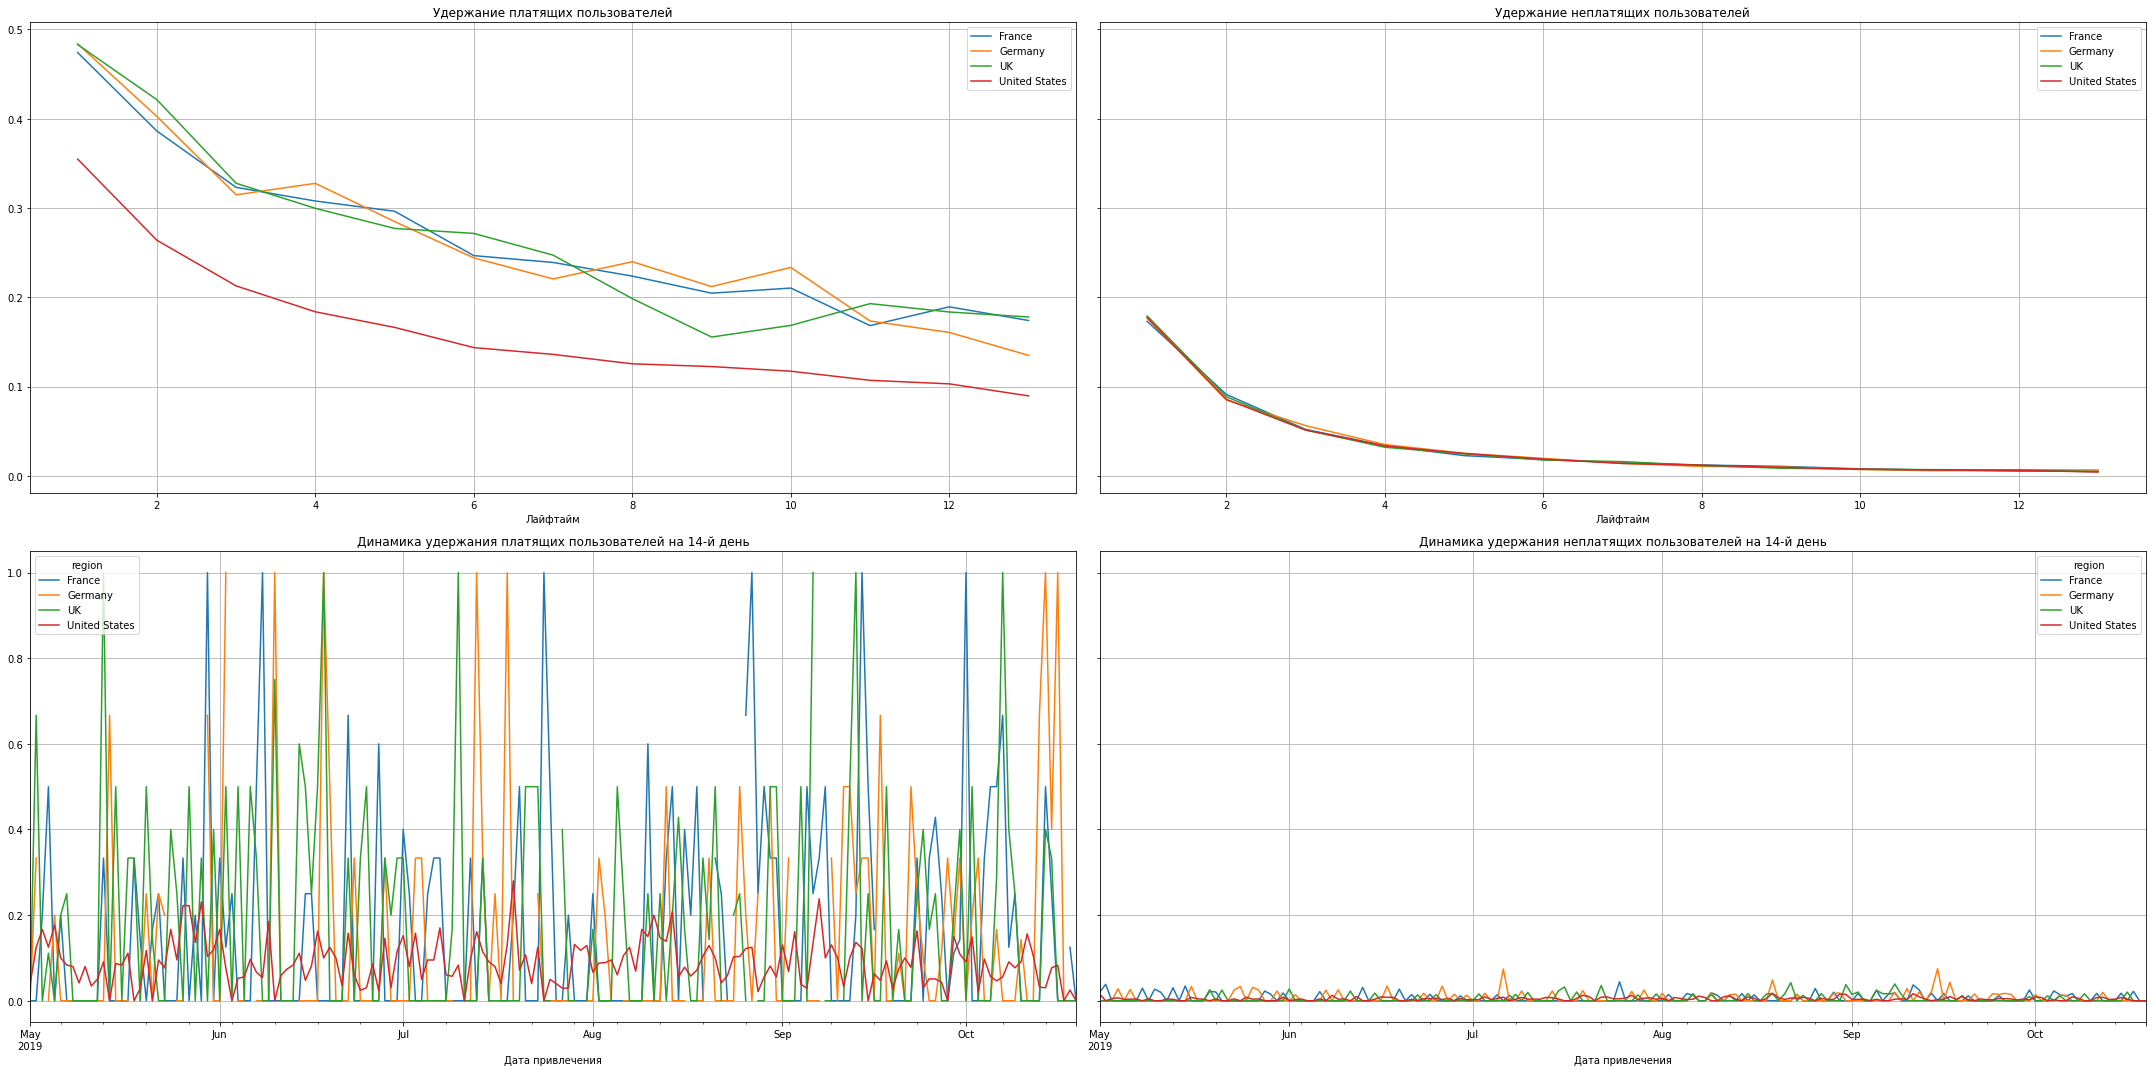

In [45]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_no_orgnic, visits, observation_date, horizon_days, dimensions = ['region'])

plot_retention(retention_grouped, retention_in_time, horizon_days)

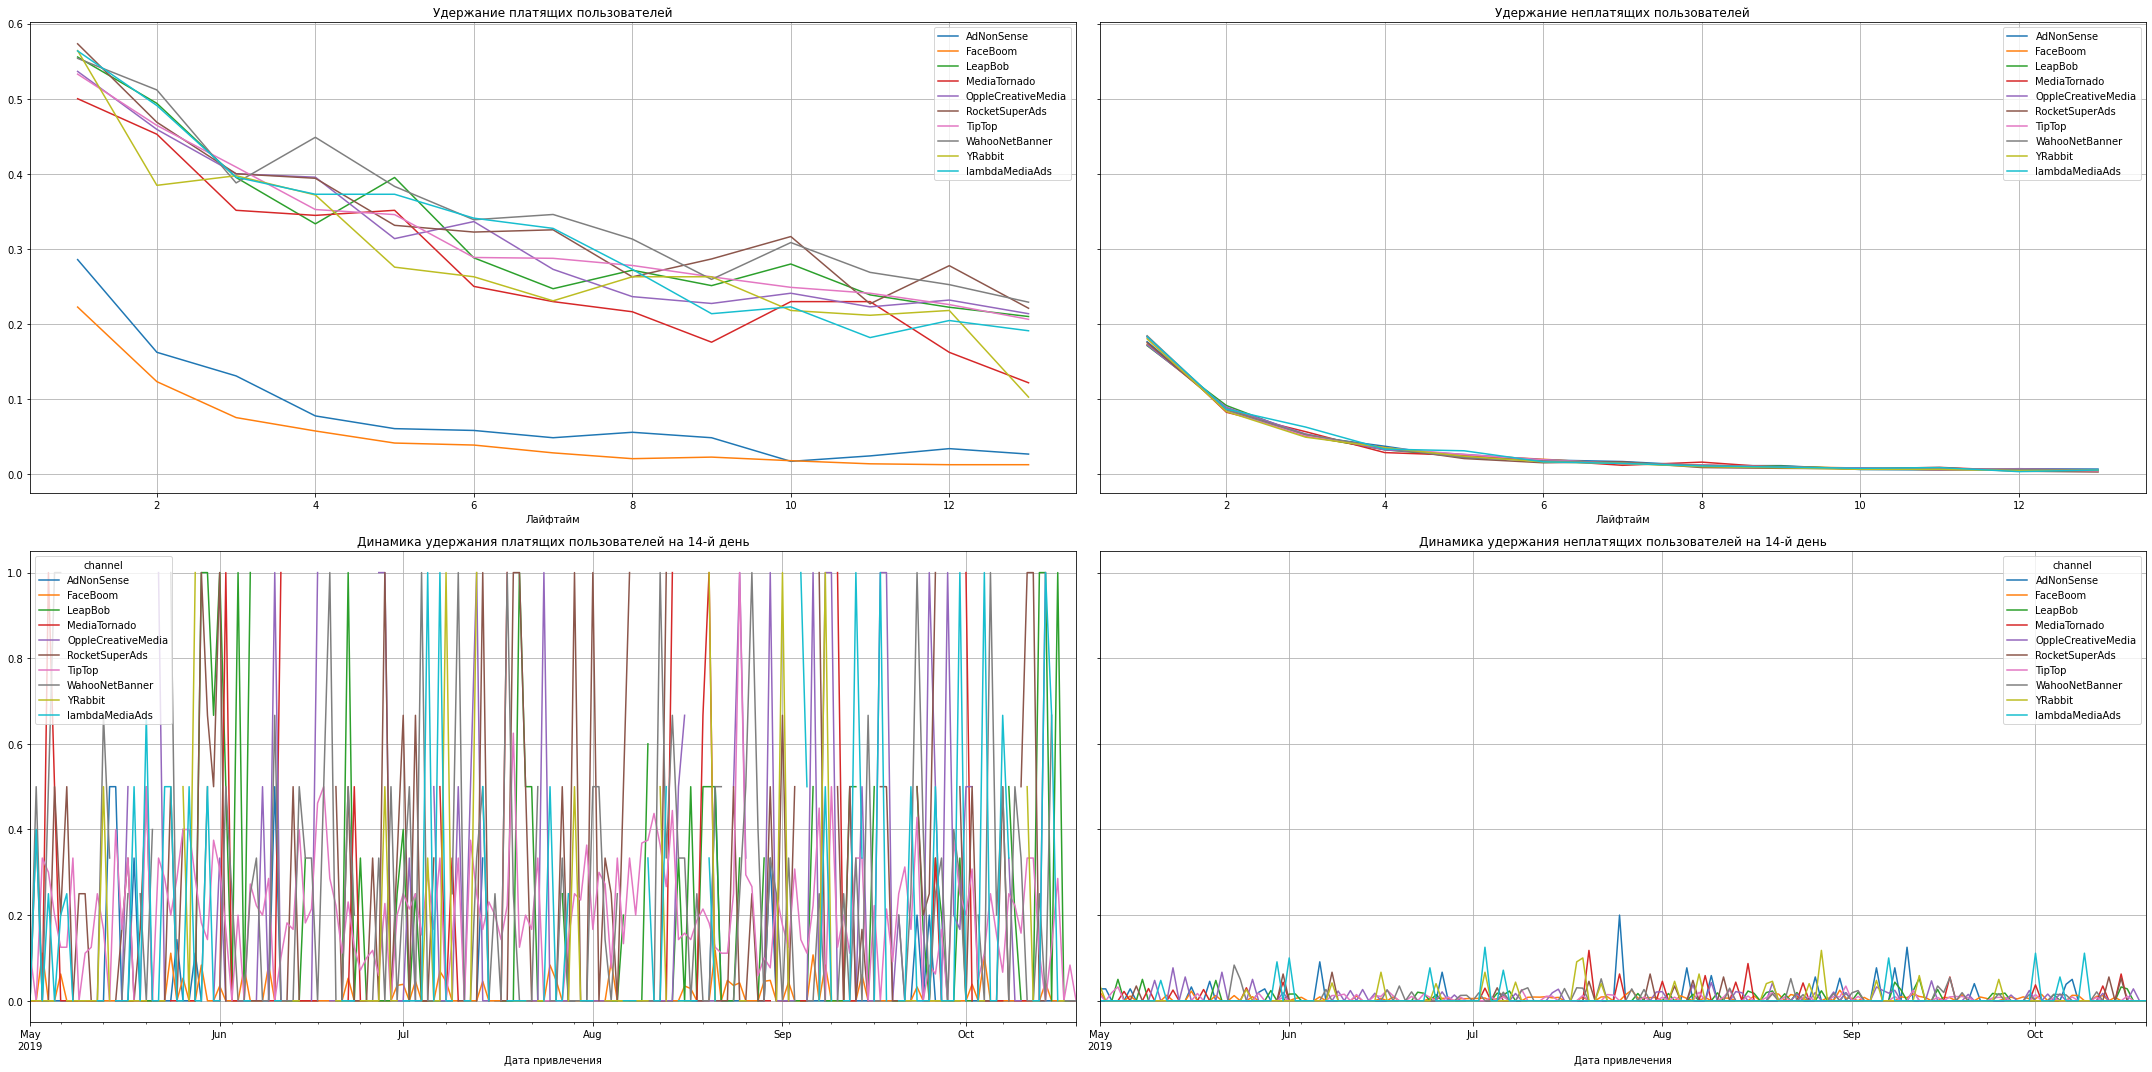

In [46]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_no_orgnic, visits, observation_date, horizon_days, dimensions = ['channel'])

plot_retention(retention_grouped, retention_in_time, horizon_days)


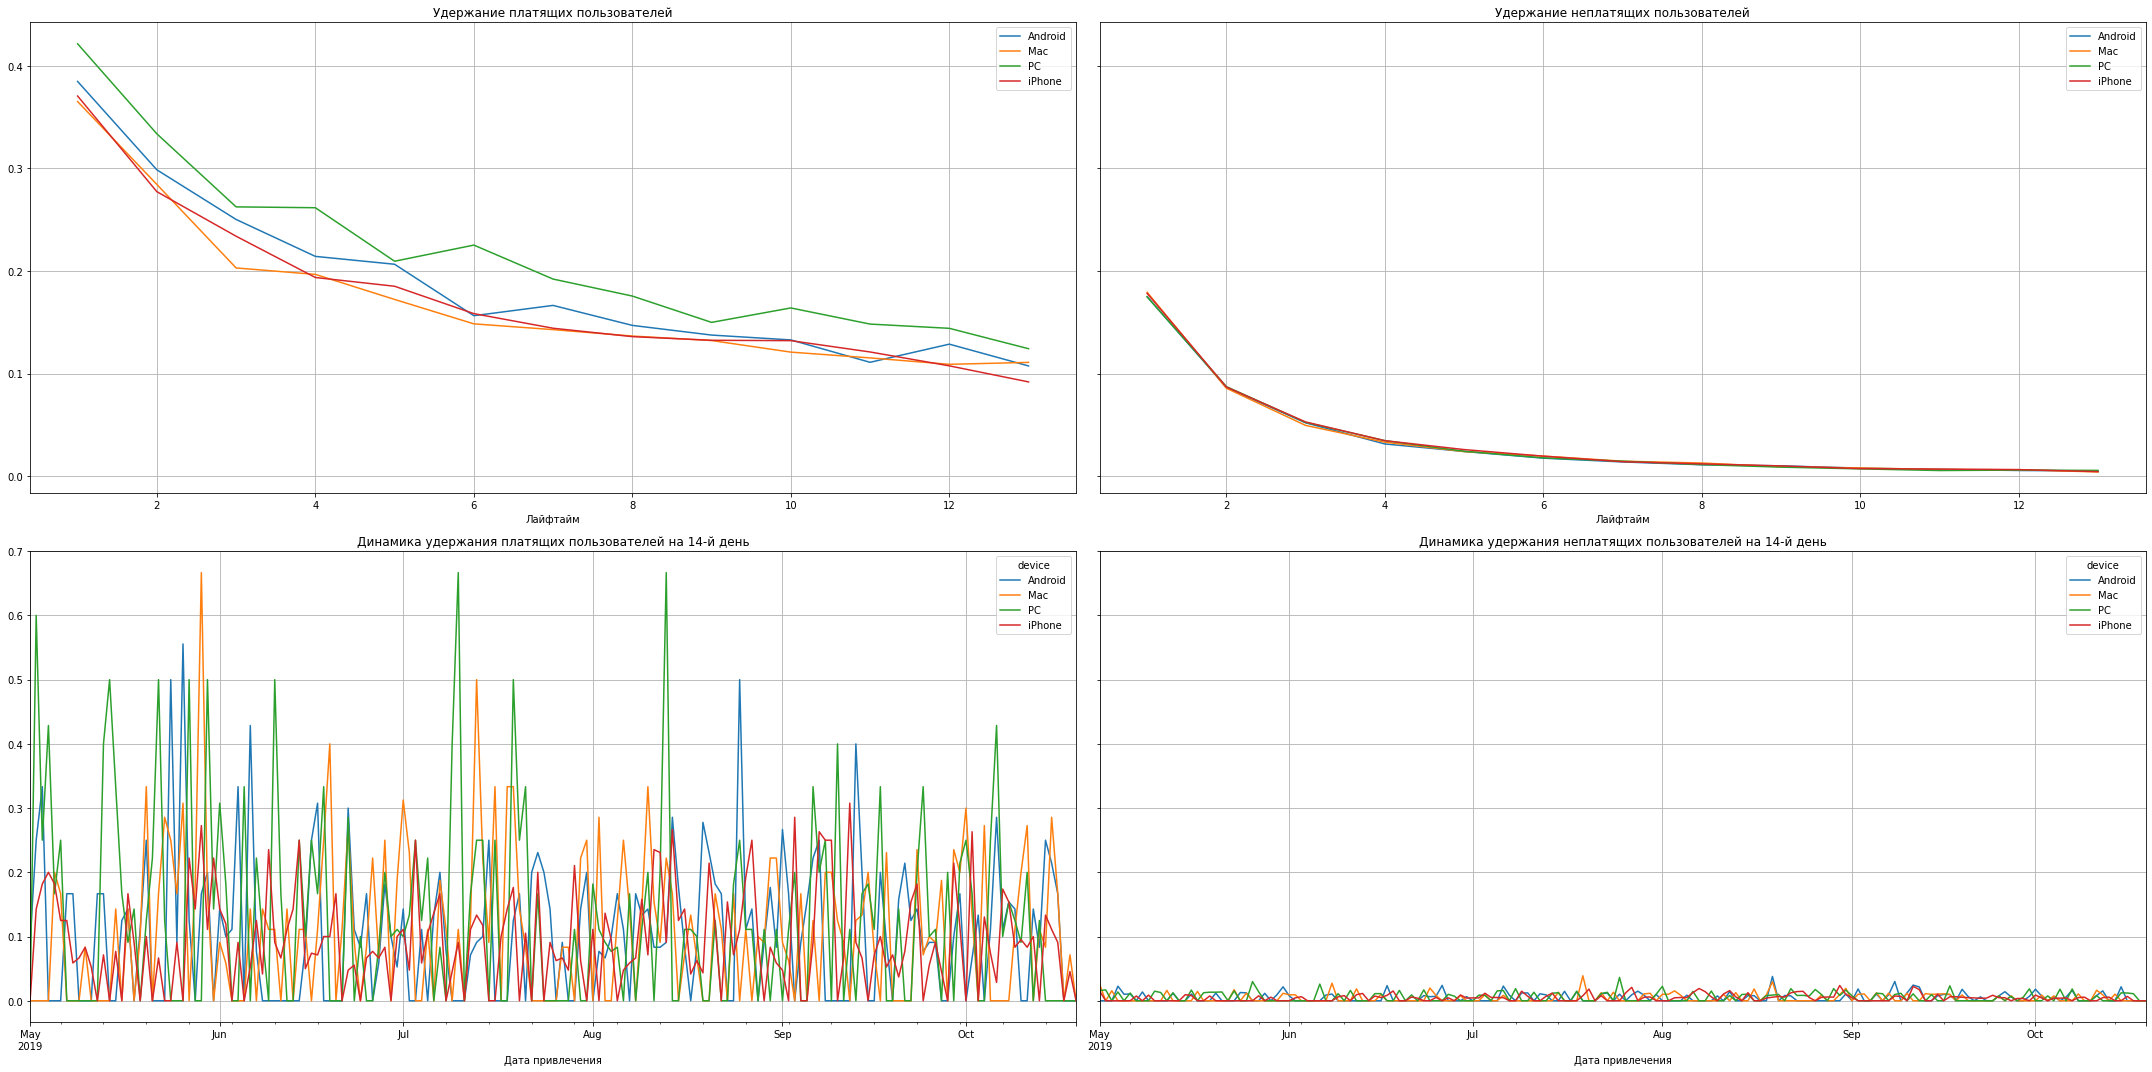

In [47]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_no_orgnic, visits, observation_date, horizon_days, dimensions = ['device'])

plot_retention(retention_grouped, retention_in_time, horizon_days)


Удержание платящих пользователей очень страдает в США, оно находится на самом нижнем уровне, а для неплатящих оно примерно равно по регонам и резко падает уже к 4 дню. Но если рассматривать именно динамику привлечения платящих пользователей, то для США она наиболее стабильно, хоть и крайне низка. 
FaceBoom и AdNonSense показывают худшие результаты по удержанию неплатящих пользователей.
Лучше всего удержание платящих пользователей происходит среди тех, кто для использования приложения предпочитает PC, дл неплатящих девайся находятся на одном уровне.

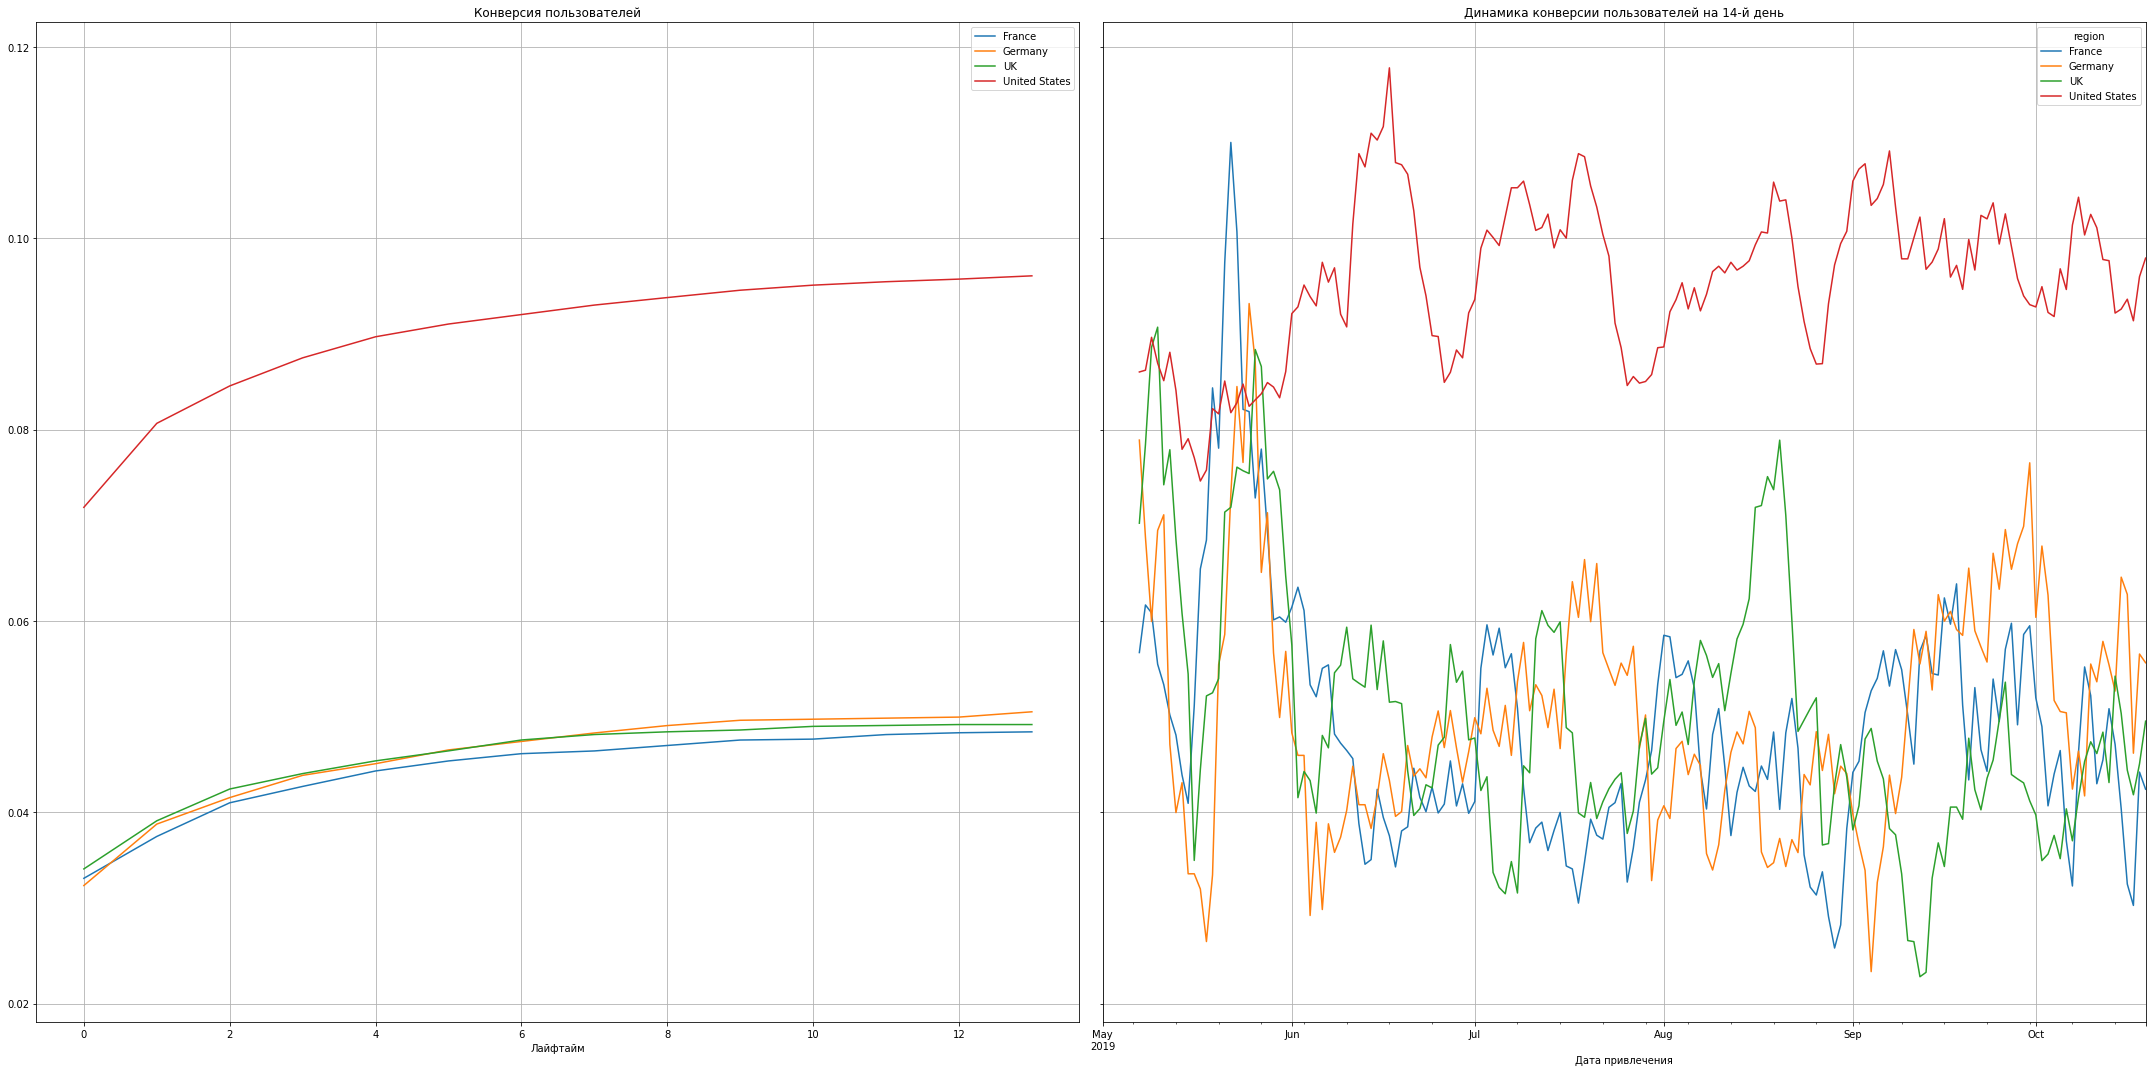

In [48]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles_no_orgnic, orders, observation_date, horizon_days, dimensions = ['region'])

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

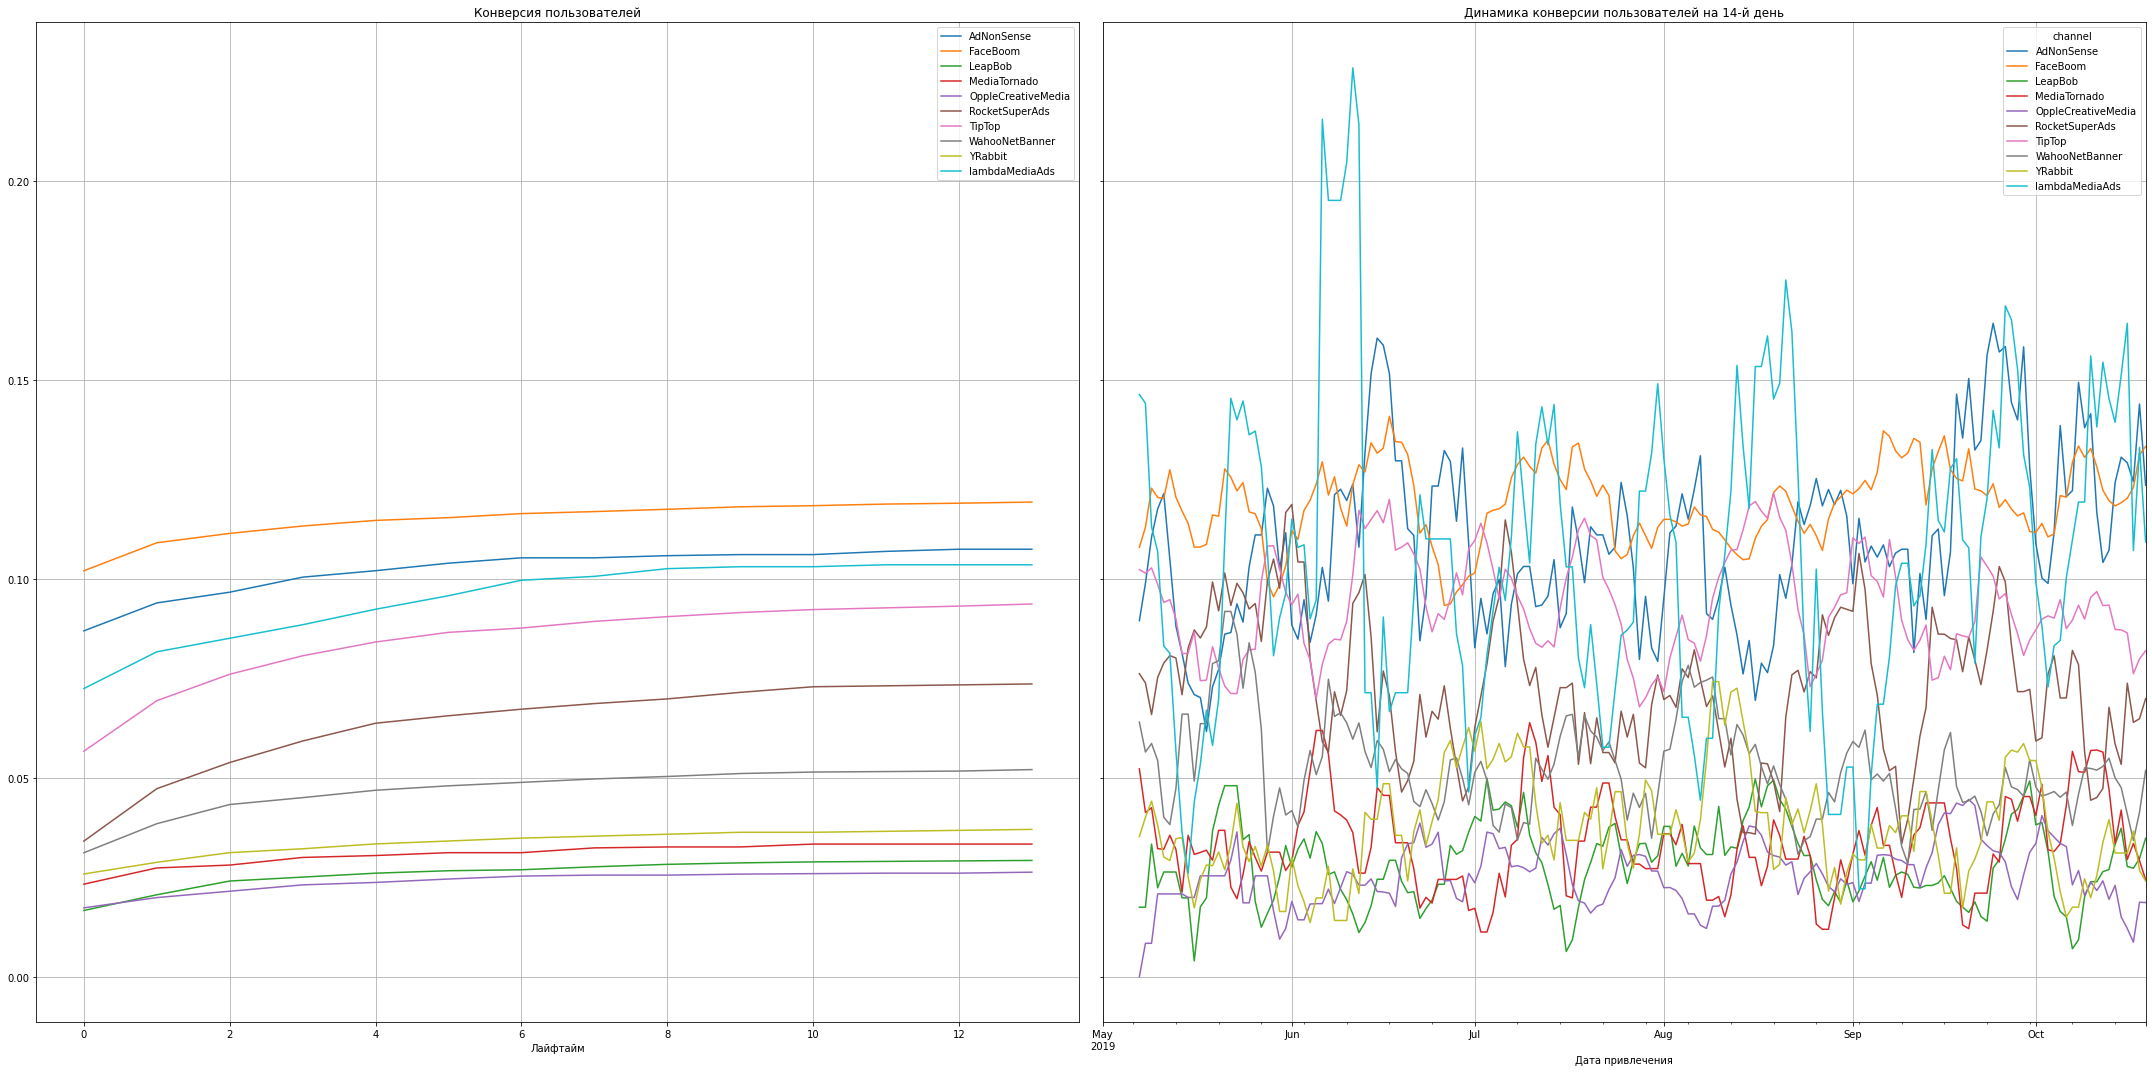

In [49]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles_no_orgnic, orders, observation_date, horizon_days,dimensions = ['channel'])

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

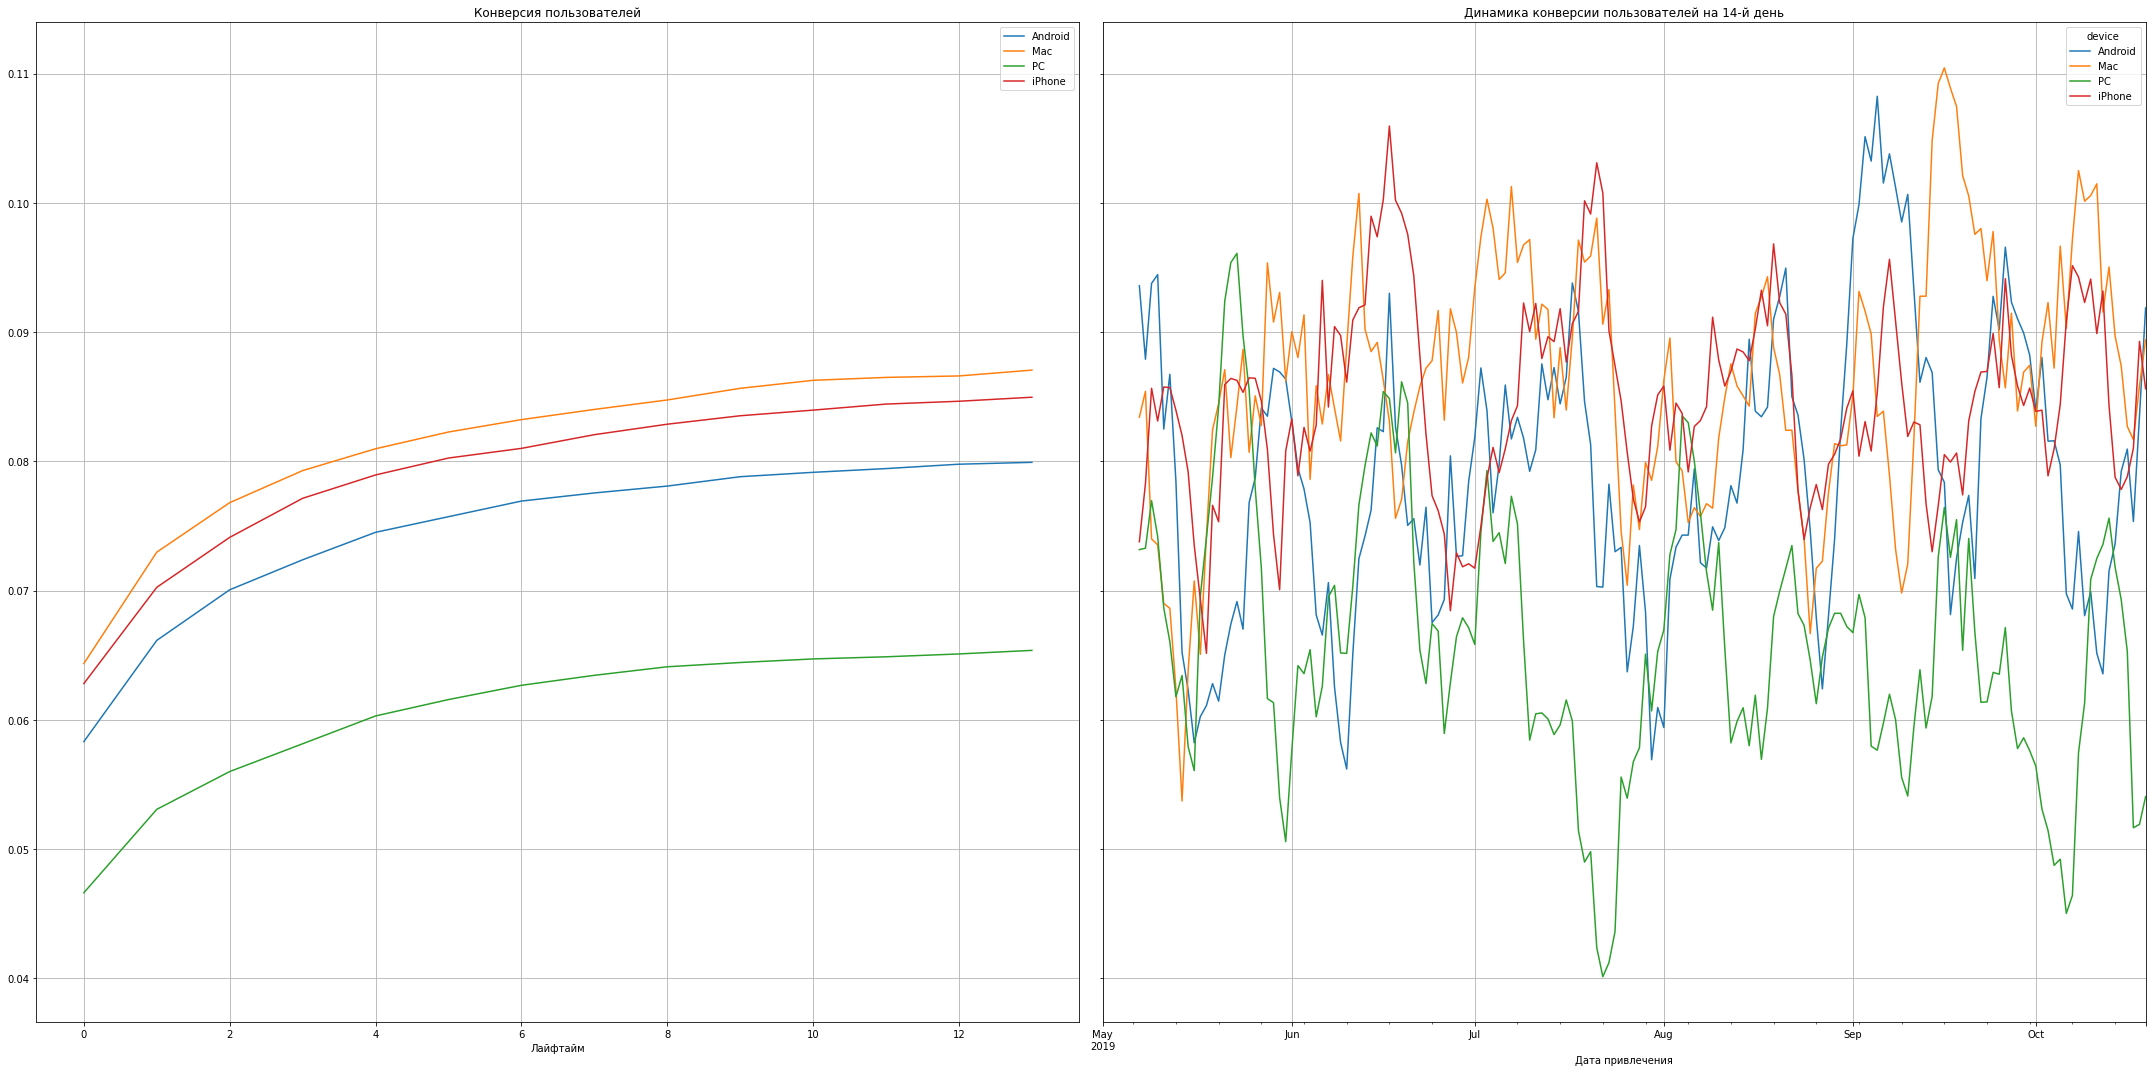

In [50]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles_no_orgnic, orders, observation_date, horizon_days,dimensions = ['device'])

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

По каналам рекламы лучшая конверсия у FaceBoom, LambdaMediaAds и AdNonSense. LambdaMediaAds чаще остальных переводит пользователей в ряды платящих на протяжении исследуемого периода, тем не менее график все-таки очень хаотичный.
По регионам самый высокий показатель конверсии в США, это опять же может быть связано с тем, что из США в принципе приходит наибольшее количество пользователей, но там и населения больше.
Как и ранее было продемонстрировано, пользователи PC демонстрируют худшие результаты по конверсии в платящих. Чаще всего платящими все-таки становятся владельцы iPhone и Mac. 
Все три графика показывают, что в определенный момент рост конверсии прекращается.

Проблемы окупаемости могут быть вызваны несколькими факторами, но один из них, возможно самый важный, некорректное распределение затрат по каналам рекламы, по девайсам и по регионам, так как на примере региона США и канала TipTop можно сделать вывод, что в них поступаю излишние инвестиции, которые не окупаются, и которые можно было бы отправить в другое направление, что могло бы помочь и привлечению новых платящих пользователей, то есть повлечь за собой окупаемость затрат. 
Скорее всего, было принято решение отдавать бОльшие инвестиции в те направления, которые вроде бы приносили больше всего платящих клиентов, но возможно анализ был не точный и следовала акцентировать внимание на других направлениях.

То есть на окупаемость рекламы могут негативно влиять лишние инвестиции в рекламу в США, в каналах рекламы TipTop, FaceBoom и рекламу на mac и iPhone, android показывает немного спорные результаты, хоть реклама и тоже не преодолевает уровень окупаемости. Эти направления для рекламы берут достаточно много инвестиций, но отдача от них не так хороша. Стоит пересмотреть распределение денежных средств и рассмотреть потенциал других направлений.

# Вывод
Метрики продемонстрировали, что работа отдела маркетинга выполняется недостаточно эффективно. Большая часть затрат уходит на каналы рекламы, девайсы и регионы, которые не приносят в дальнейшем значительной прибыли компании. Так, касательно каналов рекламы, наибольшое кол-во средств вкладывается каналы FaceBoom, AdNonSense, хотя по удержанию платящих пользователей они являются менее успешными, чем LambdaMediaAds, данный канал демонстрирует более хорошие показатели конверсии пользователей платящих, удержанию и окупаемости, лучший показатель LTV в динамике. Для канала TipTop стоит снизить расходы, так как они растут слишком быстро, что мешает окупаемости, хотя в остальном данный канал рекламы показывает себя достаточно хорошо.
Касательно регионов, наибольшие затраты уходят на США, но в данном регионе плохие показатели окупаемости привлечения пользователей, что может быть связано просто с излишними инвестициями, низкие показатели удержания. Стоит обратить внимание на регион UK, он хорошо окупается, и показывает один из лучших показателей удержания платящих клиентов. 
Из девайсов стоит обратить внимание на PC, несмотря на не самые хорошие показатели конверсии, данный вид устройств все-таки пользуется спросом среди пользователей, так как лучше всего удержание происходит именно на нем, а затраты на него окупаются.
